In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
# Atype = CuArray{Float32}

KnetArray{Float32, N} where N

In [2]:
const F = Float32
params = Knet.params

params (generic function with 2 methods)

In [3]:
logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

In [4]:
include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [5]:
dataset_name = "mnist"
notebook_name = "Variational_GON_MNIST_w_BN" * "_" * dataset_name

if !isdir("Results")
   mkdir("Results") 
end
if  !isdir(joinpath("Results", notebook_name))
    mkdir(joinpath("Results", notebook_name))
end

if  !isdir(joinpath("Results", notebook_name, "Saved_Models"))
    mkdir(joinpath("Results", notebook_name, "Saved_Models"))
end

if  !isdir(joinpath("Results", notebook_name, "Images"))
    mkdir(joinpath("Results", notebook_name, "Images"))
end

if  !isdir(joinpath("Results", notebook_name, "Logger"))
    mkdir(joinpath("Results", notebook_name, "Logger"))
end

In [6]:
push!(logger, DefaultHandler(joinpath("Results", notebook_name, "Logger", "logger.log"),DefaultFormatter("[{date} | {level} | {name}]: {msg}")));

In [7]:
use_saved_data = true

if dataset_name == "mnist"
    
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = atype);

,,,,,,,,,

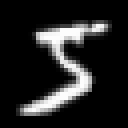
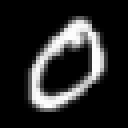
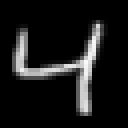
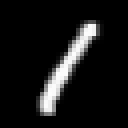
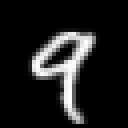
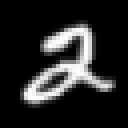
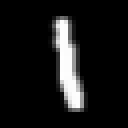
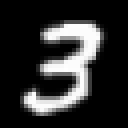
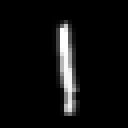
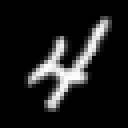

In [8]:
k = 1:10
if use_saved_data
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,:,j], (32, 32))) for j in k]
else
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]
end

In [9]:
function weights(nz, ngf) 
    
    # Decoding Weights
    theta = [] # z -> x

    w, b = linlayer_weight_init(nz, nz;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    
    w, b = linlayer_weight_init(nz, nz;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    
    w, b = deconv_weight_init(4, 4, nz, ngf * 4;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 4))) # Batch Normalization
    
    w, b = deconv_weight_init(4, 4, ngf * 4, ngf * 2;bias= true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 2)))
    
    w, b = deconv_weight_init(4, 4, ngf * 2, ngf;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf)))
    
    w,b = deconv_weight_init(4,4,ngf, 1;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    
    theta = map(a->convert(atype,a), theta)
#     theta = map(a->convert(Param,a), theta)
    
    return Param.(theta)
end

weights (generic function with 1 method)

In [10]:
## THE FOLLOWING FUNCTION IS ADDED TO THE MODULE LayerUtility.jl

# function mybatchnorm(x, moments, bparam; training = true)
#     bparam_dim =  size(bparam,1)
#     g = reshape(bparam[1:bparam_dim/2], (1,1,Int(bparam_dim/2), 1))
#     b = reshape(bparam[bparam_dim/2 + 1 : bparam_dim], (1,1,Int(bparam_dim/2), 1))
#     return g.* batchnorm(x, moments; training = training) .+ b
# end

function reparametrize(mu, logvar)
    
    std = exp.(0.5 .* logvar)
    epsilon = convert(atype, randn(F, size(mu)))
    z = mu .+ epsilon .* std
    
    return z
end

moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()

function decode(theta, z; batch_size = 64, training = true)
    
    mu = theta[1] * z .+ theta[2]
    logvar = theta[3] * z .+ theta[4]
    
    z = reparametrize(mu, logvar)
    
    z = reshape(z, (1, 1, nz, batch_size))
    z = deconv4(theta[5], z, mode = 1) .+ theta[6]
    z = mybatchnorm(z, moments1, theta[7]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[8], z, stride = 2, padding = 1, mode = 1) .+ theta[9]
    z = mybatchnorm(z, moments2, theta[10]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[11], z, stride = 2, padding = 1, mode = 1) .+ theta[12]
    z = mybatchnorm(z, moments3, theta[13]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[14], z, stride = 2, padding = 1, mode = 1) .+ theta[15]
    x_hat = Knet.sigm.(z)

    return x_hat, mu, logvar
end

function GONsample(theta, nz, batch_size; training = true)

    z = atype(randn(1,1, nz, batch_size))
    
    z = deconv4(theta[5], z, mode = 1) .+ theta[6]
    z = mybatchnorm(z, moments1, theta[7]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[8], z, stride = 2, padding = 1, mode = 1) .+ theta[9]
    z = mybatchnorm(z, moments2, theta[10]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[11], z, stride = 2, padding = 1, mode = 1) .+ theta[12]
    z = mybatchnorm(z, moments3, theta[13]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[14], z, stride = 2, padding = 1, mode = 1) .+ theta[15]
    x_hat = Knet.sigm.(z)

    return x_hat
end

GONsample (generic function with 1 method)

In [11]:
function loss(theta, x, z)
    x_hat, mu, logvar = decode(theta, z)
    L = BCE(x, x_hat) + KLD(mu, logvar)
    return L
end

function decode_train(theta, x; batch_size = 64,training = true)
    origin = Param(atype(zeros(nz, batch_size)))

    derivative_origin = @diff loss(theta, x, origin)
    dz = grad(derivative_origin, origin)
    z = -dz
    x_hat, mu, logvar = decode(theta, z; training = training);
    return x_hat, mu, logvar
end

function loss_train(theta, x)
    x_hat, mu, logvar = decode_train(theta, x; batch_size = size(x,4))
    L = BCE(x, x_hat) + KLD(mu, logvar)
    return L
end

function loss_train(theta, d::Data)
    total_loss = 0
    n_instance = 0
    for x in d
        total_loss += loss_train(theta, x) * size(x,4)
        n_instance += size(x,4)
    end

    total_loss /= n_instance
end

## Sum Squared Error Definition
rec_loss(m, w ,x) = sum((x - m(w, x; batch_size = size(x,4))[1]).^2) / size(x,4)

function rec_loss(m, w, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += rec_loss(m, w, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

rec_loss (generic function with 2 methods)

In [12]:
nz = 48
ngf = 32
nc = 1

# first batch of the test dataset
x_test_first = first(dtrn);

# Initialize random model weights
theta = weights(nz, ngf);

# Define Learning Rate and Number of Epochs
lr = 1e-3
n_epochs = 1000

# Initialize Empty Lists for both training and test losses
trn_loss_list = Float64[]
tst_loss_list =Float64[]
trn_rec_loss_list = Float64[]
tst_rec_loss_list = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)
epoch_rec_loss_trn_ = rec_loss(decode_train, theta, dtrn)
epoch_rec_loss_tst_ = rec_loss(decode_train, theta, dtst)

push!(trn_loss_list, epoch_loss_trn_)
push!(tst_loss_list, epoch_loss_tst_)
push!(trn_rec_loss_list, epoch_rec_loss_trn_)
push!(tst_rec_loss_list, epoch_rec_loss_tst_)

println("Epoch : ", 0)
println("Train Loss : ",epoch_loss_trn_)
println("Test Loss : ", epoch_loss_tst_)
println("Train Reconstruction Loss : ", epoch_rec_loss_trn_)
println("Test Reconstruction Loss : ", epoch_rec_loss_tst_)

info(logger, ("Epoch : 0"))
info(logger, ("Train Loss : $epoch_loss_trn_"))
info(logger, ("Test Loss : $epoch_loss_tst_"))
info(logger, ("Train Reconstruction Loss : $epoch_rec_loss_trn_"))
info(logger, ("Test Reconstruction Loss : $epoch_rec_loss_tst_ \n"))

# Define the step number of model save checkpoint
model_save_checkpoint = 50
logger_checkpoint = 5
image_rec_checkpoint = 25

# Training Loop
for epoch in progress(1:n_epochs)
    
    # DECREASE LEARNING RATE AFTER 50 EPOCHS
    if epoch > 50
       lr = 1e-4 
    end
    
    for (i,x) in enumerate(dtrn)
        
        # CALCULATE THE GRADIENT OF THE LOSS FUNCTION W.R.T. MODEL WEIGHTS
        derivative_model = @diff loss_train(theta, x)
        
        # UPDATE MODEL WEIGHTS WITH ADAM OPTIMIZER
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999))
        end
        
    end
    
    # Record Training and Test Losses
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    epoch_rec_loss_trn = rec_loss(decode_train, theta, dtrn)
    epoch_rec_loss_tst = rec_loss(decode_train, theta, dtst)
    
    push!(trn_loss_list, epoch_loss_trn)
    push!(tst_loss_list, epoch_loss_tst)
    push!(trn_rec_loss_list, epoch_rec_loss_trn)
    push!(tst_rec_loss_list, epoch_rec_loss_tst)
    
#     println("Epoch : ", epoch)
#     println("Train Loss : ",epoch_loss_trn)
#     println("Test Loss : ", epoch_loss_tst)
#     println("Train Reconstruction Loss : ", epoch_rec_loss_trn)
#     println("Test Reconstruction Loss : ", epoch_rec_loss_tst)
    
    # Print losses to the logger file
    if epoch % logger_checkpoint == 0
        info(logger,"Epoch : $epoch")
        info(logger,"Train Loss : $epoch_loss_trn")
        info(logger,"Test Loss : $epoch_loss_tst")
        info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
        info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")
    end
    
    # Save Model Weights 
    if epoch % model_save_checkpoint == 0
        model_id = 1000 + epoch
        model_name = joinpath("Results", notebook_name, "Saved_Models","Model_VAEGON$model_id.jld2")
        #Knet.save(model_name,"model",theta) 
        w = Dict(:decoder => theta)
        Knet.save(model_name,"model",w) 
        ### TO LOAD THE MODEL WEIGHTS, USE THE FOLLOWING
        # w = Knet.load(model_name,"model",) # Ex: model_name = "Results/Conv_AutoEncoder_Baseline_MNIST/Saved_Models/Model_Base1500.jld2"
        # theta = w[:decoder]
    end
    
    if (epoch-1) % image_rec_checkpoint == 0 
        
        # Plot and Save Reconstruction Images
        origin2 = Param(atype(zeros(nz, batch_size)))
        derivative_origin = @diff loss(theta, x_test_first, origin2)
        dz2 = grad(derivative_origin, origin2)
        z2 = -dz2
        x_hat, mu, logvar = decode(theta, z2)

        plot_reconstructed_images(x_test_first, x_hat, 10, batch_size, (900,300))
        fig_name = "Reconstructed_Imgs_ID" * string(1000 + epoch) 
        savefig(joinpath("Results", notebook_name, "Images", fig_name))

        x_sampled = GONsample(theta, nz, 64)
        plot_image_grid(x_sampled; grid_x_size = 8, grid_y_size = 8, title = "VAE GON Sampled Images")
        fig_name = "VAEGON_Sampled_Imgs_ID" * string(1000 + epoch) 
        savefig(joinpath("Results", notebook_name, "Images", fig_name))

    end
end

Epoch : 0
Train Loss : 1084.020034781038
Test Loss : 1083.06220222169
Train Reconstruction Loss : 356.4441
Test Reconstruction Loss : 356.3148
[2021-12-08 11:55:27 | info | root]: Epoch : 0
[2021-12-08 11:55:27 | info | root]: Train Loss : 1084.020034781038
[2021-12-08 11:55:27 | info | root]: Test Loss : 1083.06220222169
[2021-12-08 11:55:27 | info | root]: Train Reconstruction Loss : 356.4441
[2021-12-08 11:55:27 | info | root]: Test Reconstruction Loss : 356.3148 



┣                    ┫ [0.50%, 5/1000, 02:45/09:11:21, 32.50s/i] 

[2021-12-08 11:58:46 | info | root]: Epoch : 5
[2021-12-08 11:58:46 | info | root]: Train Loss : 169.7892092864567
[2021-12-08 11:58:46 | info | root]: Test Loss : 173.46840562575903
[2021-12-08 11:58:46 | info | root]: Train Reconstruction Loss : 17.18748
[2021-12-08 11:58:46 | info | root]: Test Reconstruction Loss : 18.553438 



┣▏                   ┫ [1.00%, 10/1000, 05:29/09:07:44, 32.68s/i] 

[2021-12-08 12:01:30 | info | root]: Epoch : 10
[2021-12-08 12:01:30 | info | root]: Train Loss : 161.64510546982478
[2021-12-08 12:01:30 | info | root]: Test Loss : 164.90123514028696
[2021-12-08 12:01:30 | info | root]: Train Reconstruction Loss : 14.093423
[2021-12-08 12:01:30 | info | root]: Test Reconstruction Loss : 15.264197 



┣▎                   ┫ [1.50%, 15/1000, 08:12/09:07:00, 33.07s/i] 

[2021-12-08 12:04:13 | info | root]: Epoch : 15
[2021-12-08 12:04:13 | info | root]: Train Loss : 158.35997167646312
[2021-12-08 12:04:13 | info | root]: Test Loss : 161.23992660718088
[2021-12-08 12:04:13 | info | root]: Train Reconstruction Loss : 12.757082
[2021-12-08 12:04:13 | info | root]: Test Reconstruction Loss : 13.8502 



┣▍                   ┫ [2.00%, 20/1000, 10:57/09:07:36, 33.19s/i] ┫ [1.90%, 19/1000, 10:24/09:07:19, 32.96s/i] 

[2021-12-08 12:06:58 | info | root]: Epoch : 20
[2021-12-08 12:06:58 | info | root]: Train Loss : 156.09355076043812
[2021-12-08 12:06:58 | info | root]: Test Loss : 158.87694234114426
[2021-12-08 12:06:58 | info | root]: Train Reconstruction Loss : 11.825232
[2021-12-08 12:06:58 | info | root]: Test Reconstruction Loss : 12.926547 



┣▌                   ┫ [2.50%, 25/1000, 13:42/09:08:18, 33.32s/i] 

[2021-12-08 12:09:44 | info | root]: Epoch : 25
[2021-12-08 12:09:44 | info | root]: Train Loss : 154.5980106850444
[2021-12-08 12:09:44 | info | root]: Test Loss : 157.4026038830097
[2021-12-08 12:09:44 | info | root]: Train Reconstruction Loss : 11.206085
[2021-12-08 12:09:44 | info | root]: Test Reconstruction Loss : 12.281675 



┣▌                   ┫ [3.00%, 30/1000, 16:31/09:10:45, 33.14s/i] 

[2021-12-08 12:12:33 | info | root]: Epoch : 30
[2021-12-08 12:12:33 | info | root]: Train Loss : 154.30359315821303
[2021-12-08 12:12:33 | info | root]: Test Loss : 157.16277882991693
[2021-12-08 12:12:33 | info | root]: Train Reconstruction Loss : 11.065272
[2021-12-08 12:12:33 | info | root]: Test Reconstruction Loss : 12.120366 



┣▋                   ┫ [3.50%, 35/1000, 19:18/09:11:40, 33.68s/i] 

[2021-12-08 12:15:20 | info | root]: Epoch : 35
[2021-12-08 12:15:20 | info | root]: Train Loss : 153.78777610835806
[2021-12-08 12:15:20 | info | root]: Test Loss : 156.3503228456546
[2021-12-08 12:15:20 | info | root]: Train Reconstruction Loss : 10.869592
[2021-12-08 12:15:20 | info | root]: Test Reconstruction Loss : 11.862093 



┣▊                   ┫ [4.00%, 40/1000, 22:07/09:12:53, 33.89s/i] 

[2021-12-08 12:18:09 | info | root]: Epoch : 40
[2021-12-08 12:18:09 | info | root]: Train Loss : 153.13811565590515
[2021-12-08 12:18:09 | info | root]: Test Loss : 155.6377846522209
[2021-12-08 12:18:09 | info | root]: Train Reconstruction Loss : 10.713449
[2021-12-08 12:18:09 | info | root]: Test Reconstruction Loss : 11.612808 



┣▉                   ┫ [4.50%, 45/1000, 24:59/09:15:05, 34.25s/i] 

[2021-12-08 12:21:00 | info | root]: Epoch : 45
[2021-12-08 12:21:00 | info | root]: Train Loss : 152.91577174289503
[2021-12-08 12:21:00 | info | root]: Test Loss : 155.67708729474973
[2021-12-08 12:21:00 | info | root]: Train Reconstruction Loss : 10.595081
[2021-12-08 12:21:00 | info | root]: Test Reconstruction Loss : 11.651753 



┣█                   ┫ [5.00%, 50/1000, 27:42/09:13:55, 32.37s/i] 

[2021-12-08 12:23:42 | info | root]: Epoch : 50
[2021-12-08 12:23:42 | info | root]: Train Loss : 152.57269633770497
[2021-12-08 12:23:42 | info | root]: Test Loss : 155.40451606114706
[2021-12-08 12:23:42 | info | root]: Train Reconstruction Loss : 10.516458
[2021-12-08 12:23:42 | info | root]: Test Reconstruction Loss : 11.564117 



┣█                   ┫ [5.50%, 55/1000, 30:36/09:16:13, 32.54s/i] 

[2021-12-08 12:26:35 | info | root]: Epoch : 55
[2021-12-08 12:26:35 | info | root]: Train Loss : 151.13921905200027
[2021-12-08 12:26:35 | info | root]: Test Loss : 153.72937646278967
[2021-12-08 12:26:35 | info | root]: Train Reconstruction Loss : 9.985429
[2021-12-08 12:26:35 | info | root]: Test Reconstruction Loss : 10.940992 



┣█▏                  ┫ [6.00%, 60/1000, 33:16/09:14:22, 32.01s/i] 

[2021-12-08 12:29:16 | info | root]: Epoch : 60
[2021-12-08 12:29:16 | info | root]: Train Loss : 150.92191071647719
[2021-12-08 12:29:16 | info | root]: Test Loss : 153.52595755992792
[2021-12-08 12:29:16 | info | root]: Train Reconstruction Loss : 9.919383
[2021-12-08 12:29:16 | info | root]: Test Reconstruction Loss : 10.8159075 



┣█▎                  ┫ [6.50%, 65/1000, 36:00/09:13:50, 32.69s/i] 

[2021-12-08 12:32:00 | info | root]: Epoch : 65
[2021-12-08 12:32:00 | info | root]: Train Loss : 150.80863073668587
[2021-12-08 12:32:00 | info | root]: Test Loss : 153.23584233797513
[2021-12-08 12:32:00 | info | root]: Train Reconstruction Loss : 9.860573
[2021-12-08 12:32:00 | info | root]: Test Reconstruction Loss : 10.757342 



┣█▍                  ┫ [7.00%, 70/1000, 38:41/09:12:30, 31.95s/i] 

[2021-12-08 12:34:41 | info | root]: Epoch : 70
[2021-12-08 12:34:41 | info | root]: Train Loss : 150.6452893854587
[2021-12-08 12:34:41 | info | root]: Test Loss : 153.08055959603726
[2021-12-08 12:34:41 | info | root]: Train Reconstruction Loss : 9.794742
[2021-12-08 12:34:41 | info | root]: Test Reconstruction Loss : 10.6543255 



┣█▌                  ┫ [7.50%, 75/1000, 41:24/09:11:58, 33.04s/i] 

[2021-12-08 12:37:25 | info | root]: Epoch : 75
[2021-12-08 12:37:25 | info | root]: Train Loss : 150.5681734522735
[2021-12-08 12:37:25 | info | root]: Test Loss : 152.9294333091149
[2021-12-08 12:37:25 | info | root]: Train Reconstruction Loss : 9.756597
[2021-12-08 12:37:25 | info | root]: Test Reconstruction Loss : 10.612273 



┣█▌                  ┫ [8.00%, 80/1000, 44:16/09:13:17, 33.75s/i] 

[2021-12-08 12:40:17 | info | root]: Epoch : 80
[2021-12-08 12:40:17 | info | root]: Train Loss : 150.5385777342154
[2021-12-08 12:40:17 | info | root]: Test Loss : 152.99248750393207
[2021-12-08 12:40:17 | info | root]: Train Reconstruction Loss : 9.732509
[2021-12-08 12:40:17 | info | root]: Test Reconstruction Loss : 10.619907 



┣█▋                  ┫ [8.50%, 85/1000, 47:01/09:13:08, 33.08s/i] 

[2021-12-08 12:43:02 | info | root]: Epoch : 85
[2021-12-08 12:43:02 | info | root]: Train Loss : 150.43180169112654
[2021-12-08 12:43:02 | info | root]: Test Loss : 152.62324669422247
[2021-12-08 12:43:02 | info | root]: Train Reconstruction Loss : 9.704291
[2021-12-08 12:43:02 | info | root]: Test Reconstruction Loss : 10.519661 



┣█▊                  ┫ [9.00%, 90/1000, 49:47/09:13:07, 33.28s/i] 

[2021-12-08 12:45:48 | info | root]: Epoch : 90
[2021-12-08 12:45:48 | info | root]: Train Loss : 150.34950806364307
[2021-12-08 12:45:48 | info | root]: Test Loss : 152.71958627456274
[2021-12-08 12:45:48 | info | root]: Train Reconstruction Loss : 9.638042
[2021-12-08 12:45:48 | info | root]: Test Reconstruction Loss : 10.540855 



┣█▉                  ┫ [9.50%, 95/1000, 52:33/09:13:08, 33.26s/i] 

[2021-12-08 12:48:34 | info | root]: Epoch : 95
[2021-12-08 12:48:34 | info | root]: Train Loss : 150.23018207163287
[2021-12-08 12:48:34 | info | root]: Test Loss : 152.63165129148044
[2021-12-08 12:48:34 | info | root]: Train Reconstruction Loss : 9.597102
[2021-12-08 12:48:34 | info | root]: Test Reconstruction Loss : 10.44822 



┣██                  ┫ [10.00%, 100/1000, 55:21/09:13:30, 33.49s/i] 

[2021-12-08 12:51:23 | info | root]: Epoch : 100
[2021-12-08 12:51:23 | info | root]: Train Loss : 150.2372192354314
[2021-12-08 12:51:23 | info | root]: Test Loss : 152.51132523707855
[2021-12-08 12:51:23 | info | root]: Train Reconstruction Loss : 9.604041
[2021-12-08 12:51:23 | info | root]: Test Reconstruction Loss : 10.405875 



┣██                  ┫ [10.50%, 105/1000, 58:24/09:16:11, 36.36s/i] 

[2021-12-08 12:54:28 | info | root]: Epoch : 105
[2021-12-08 12:54:28 | info | root]: Train Loss : 150.15296809624965
[2021-12-08 12:54:28 | info | root]: Test Loss : 152.39859720376822
[2021-12-08 12:54:28 | info | root]: Train Reconstruction Loss : 9.5812235
[2021-12-08 12:54:28 | info | root]: Test Reconstruction Loss : 10.421867 



┣██▏                 ┫ [11.00%, 110/1000, 01:01:27/09:18:37, 37.24s/i] 

[2021-12-08 12:57:32 | info | root]: Epoch : 110
[2021-12-08 12:57:32 | info | root]: Train Loss : 150.1177120493723
[2021-12-08 12:57:32 | info | root]: Test Loss : 152.39542710475433
[2021-12-08 12:57:32 | info | root]: Train Reconstruction Loss : 9.591541
[2021-12-08 12:57:32 | info | root]: Test Reconstruction Loss : 10.4472475 



┣██▎                 ┫ [11.50%, 115/1000, 01:04:33/09:21:17, 37.68s/i] 

[2021-12-08 13:00:39 | info | root]: Epoch : 115
[2021-12-08 13:00:39 | info | root]: Train Loss : 150.06230793996707
[2021-12-08 13:00:39 | info | root]: Test Loss : 152.39308516184488
[2021-12-08 13:00:39 | info | root]: Train Reconstruction Loss : 9.501984
[2021-12-08 13:00:39 | info | root]: Test Reconstruction Loss : 10.3284 



┣██▍                 ┫ [12.00%, 120/1000, 01:07:41/09:24:02, 37.86s/i] 

[2021-12-08 13:03:47 | info | root]: Epoch : 120
[2021-12-08 13:03:47 | info | root]: Train Loss : 150.00881583255537
[2021-12-08 13:03:47 | info | root]: Test Loss : 152.24341085629587
[2021-12-08 13:03:47 | info | root]: Train Reconstruction Loss : 9.516402
[2021-12-08 13:03:47 | info | root]: Test Reconstruction Loss : 10.356861 



┣██▌                 ┫ [12.50%, 125/1000, 01:10:52/09:26:58, 38.44s/i] 

[2021-12-08 13:06:59 | info | root]: Epoch : 125
[2021-12-08 13:06:59 | info | root]: Train Loss : 149.91328108145308
[2021-12-08 13:06:59 | info | root]: Test Loss : 152.3140035042396
[2021-12-08 13:06:59 | info | root]: Train Reconstruction Loss : 9.492937
[2021-12-08 13:06:59 | info | root]: Test Reconstruction Loss : 10.313152 



┣██▌                 ┫ [13.00%, 130/1000, 01:14:08/09:30:18, 39.31s/i] 

[2021-12-08 13:10:16 | info | root]: Epoch : 130
[2021-12-08 13:10:16 | info | root]: Train Loss : 149.91949830721893
[2021-12-08 13:10:16 | info | root]: Test Loss : 152.30922392087106
[2021-12-08 13:10:16 | info | root]: Train Reconstruction Loss : 9.4938135
[2021-12-08 13:10:16 | info | root]: Test Reconstruction Loss : 10.360367 



┣██▋                 ┫ [13.50%, 135/1000, 01:17:31/09:34:11, 41.67s/i] 

[2021-12-08 13:13:41 | info | root]: Epoch : 135
[2021-12-08 13:13:41 | info | root]: Train Loss : 149.88026067719517
[2021-12-08 13:13:41 | info | root]: Test Loss : 152.2014246720534
[2021-12-08 13:13:41 | info | root]: Train Reconstruction Loss : 9.457536
[2021-12-08 13:13:41 | info | root]: Test Reconstruction Loss : 10.286464 



┣██▊                 ┫ [14.00%, 140/1000, 01:21:17/09:40:37, 49.83s/i] 

[2021-12-08 13:17:21 | info | root]: Epoch : 140
[2021-12-08 13:17:21 | info | root]: Train Loss : 149.8533411667212
[2021-12-08 13:17:21 | info | root]: Test Loss : 152.17841263306445
[2021-12-08 13:17:21 | info | root]: Train Reconstruction Loss : 9.461902
[2021-12-08 13:17:21 | info | root]: Test Reconstruction Loss : 10.3050585 



┣██▉                 ┫ [14.50%, 145/1000, 01:24:08/09:40:16, 33.40s/i] 

[2021-12-08 13:20:10 | info | root]: Epoch : 145
[2021-12-08 13:20:10 | info | root]: Train Loss : 149.8198674730201
[2021-12-08 13:20:10 | info | root]: Test Loss : 151.96580538382898
[2021-12-08 13:20:10 | info | root]: Train Reconstruction Loss : 9.420014
[2021-12-08 13:20:10 | info | root]: Test Reconstruction Loss : 10.240575 



┣███                 ┫ [15.00%, 150/1000, 01:26:58/09:39:45, 33.66s/i] 

[2021-12-08 13:23:00 | info | root]: Epoch : 150
[2021-12-08 13:23:00 | info | root]: Train Loss : 149.80703579221745
[2021-12-08 13:23:00 | info | root]: Test Loss : 151.99078748165033
[2021-12-08 13:23:00 | info | root]: Train Reconstruction Loss : 9.4020815
[2021-12-08 13:23:00 | info | root]: Test Reconstruction Loss : 10.237123 



┣███                 ┫ [15.50%, 155/1000, 01:29:52/09:39:46, 34.00s/i] 

[2021-12-08 13:25:54 | info | root]: Epoch : 155
[2021-12-08 13:25:54 | info | root]: Train Loss : 149.78396797180176
[2021-12-08 13:25:54 | info | root]: Test Loss : 151.95532275468875
[2021-12-08 13:25:54 | info | root]: Train Reconstruction Loss : 9.4251
[2021-12-08 13:25:54 | info | root]: Test Reconstruction Loss : 10.224756 



┣███▏                ┫ [16.00%, 160/1000, 01:32:41/09:39:15, 33.76s/i] 

[2021-12-08 13:28:43 | info | root]: Epoch : 160
[2021-12-08 13:28:43 | info | root]: Train Loss : 149.70654324966154
[2021-12-08 13:28:43 | info | root]: Test Loss : 151.96805259508963
[2021-12-08 13:28:43 | info | root]: Train Reconstruction Loss : 9.383987
[2021-12-08 13:28:43 | info | root]: Test Reconstruction Loss : 10.215078 



┣███▎                ┫ [16.50%, 165/1000, 01:35:30/09:38:50, 34.08s/i] 

[2021-12-08 13:31:32 | info | root]: Epoch : 165
[2021-12-08 13:31:32 | info | root]: Train Loss : 149.71651160729732
[2021-12-08 13:31:32 | info | root]: Test Loss : 151.80578214694293
[2021-12-08 13:31:32 | info | root]: Train Reconstruction Loss : 9.409478
[2021-12-08 13:31:32 | info | root]: Test Reconstruction Loss : 10.239673 



┣███▍                ┫ [17.00%, 170/1000, 01:38:20/09:38:24, 33.54s/i] 

[2021-12-08 13:34:20 | info | root]: Epoch : 170
[2021-12-08 13:34:20 | info | root]: Train Loss : 149.62836688356185
[2021-12-08 13:34:20 | info | root]: Test Loss : 151.9538262807406
[2021-12-08 13:34:20 | info | root]: Train Reconstruction Loss : 9.385945
[2021-12-08 13:34:20 | info | root]: Test Reconstruction Loss : 10.205182 



┣███▌                ┫ [17.50%, 175/1000, 01:41:04/09:37:30, 32.38s/i] 

[2021-12-08 13:37:04 | info | root]: Epoch : 175
[2021-12-08 13:37:04 | info | root]: Train Loss : 149.60552084077003
[2021-12-08 13:37:04 | info | root]: Test Loss : 151.81067196528116
[2021-12-08 13:37:04 | info | root]: Train Reconstruction Loss : 9.369628
[2021-12-08 13:37:04 | info | root]: Test Reconstruction Loss : 10.216365 



┣███▌                ┫ [18.00%, 180/1000, 01:43:48/09:36:40, 33.11s/i] 

[2021-12-08 13:39:50 | info | root]: Epoch : 180
[2021-12-08 13:39:50 | info | root]: Train Loss : 149.5954563096086
[2021-12-08 13:39:50 | info | root]: Test Loss : 151.81751014024783
[2021-12-08 13:39:50 | info | root]: Train Reconstruction Loss : 9.337903
[2021-12-08 13:39:50 | info | root]: Test Reconstruction Loss : 10.178269 



┣███▋                ┫ [18.50%, 185/1000, 01:46:37/09:36:16, 33.25s/i] 

[2021-12-08 13:42:36 | info | root]: Epoch : 185
[2021-12-08 13:42:36 | info | root]: Train Loss : 149.5563828825569
[2021-12-08 13:42:36 | info | root]: Test Loss : 151.776343920292
[2021-12-08 13:42:36 | info | root]: Train Reconstruction Loss : 9.330433
[2021-12-08 13:42:36 | info | root]: Test Reconstruction Loss : 10.146519 



┣███▊                ┫ [19.00%, 190/1000, 01:49:19/09:35:20, 33.62s/i] 

[2021-12-08 13:45:21 | info | root]: Epoch : 190
[2021-12-08 13:45:21 | info | root]: Train Loss : 149.56612822900078
[2021-12-08 13:45:21 | info | root]: Test Loss : 151.8818653180049
[2021-12-08 13:45:21 | info | root]: Train Reconstruction Loss : 9.351915
[2021-12-08 13:45:21 | info | root]: Test Reconstruction Loss : 10.155482 



┣███▉                ┫ [19.50%, 195/1000, 01:52:05/09:34:48, 34.66s/i] 

[2021-12-08 13:48:07 | info | root]: Epoch : 195
[2021-12-08 13:48:07 | info | root]: Train Loss : 149.4941332989085
[2021-12-08 13:48:07 | info | root]: Test Loss : 151.68972953160605
[2021-12-08 13:48:07 | info | root]: Train Reconstruction Loss : 9.314303
[2021-12-08 13:48:07 | info | root]: Test Reconstruction Loss : 10.124465 



┣████                ┫ [20.00%, 200/1000, 01:54:53/09:34:26, 34.30s/i] 

[2021-12-08 13:50:55 | info | root]: Epoch : 200
[2021-12-08 13:50:55 | info | root]: Train Loss : 149.48971678327726
[2021-12-08 13:50:55 | info | root]: Test Loss : 151.6276533542535
[2021-12-08 13:50:55 | info | root]: Train Reconstruction Loss : 9.302243
[2021-12-08 13:50:55 | info | root]: Test Reconstruction Loss : 10.131038 



┣████                ┫ [20.50%, 205/1000, 01:57:47/09:34:31, 34.40s/i] 

[2021-12-08 13:53:49 | info | root]: Epoch : 205
[2021-12-08 13:53:49 | info | root]: Train Loss : 149.4955101623861
[2021-12-08 13:53:49 | info | root]: Test Loss : 151.67351265442676
[2021-12-08 13:53:49 | info | root]: Train Reconstruction Loss : 9.293787
[2021-12-08 13:53:49 | info | root]: Test Reconstruction Loss : 10.109778 



┣████▏               ┫ [21.00%, 210/1000, 02:00:38/09:34:27, 35.14s/i] 

[2021-12-08 13:56:41 | info | root]: Epoch : 210
[2021-12-08 13:56:41 | info | root]: Train Loss : 149.40612150739835
[2021-12-08 13:56:41 | info | root]: Test Loss : 151.5499310982533
[2021-12-08 13:56:41 | info | root]: Train Reconstruction Loss : 9.290208
[2021-12-08 13:56:41 | info | root]: Test Reconstruction Loss : 10.121056 



┣████▎               ┫ [21.50%, 215/1000, 02:03:32/09:34:33, 34.65s/i] 

[2021-12-08 13:59:33 | info | root]: Epoch : 215
[2021-12-08 13:59:33 | info | root]: Train Loss : 149.42960827887504
[2021-12-08 13:59:33 | info | root]: Test Loss : 151.67914641209137
[2021-12-08 13:59:33 | info | root]: Train Reconstruction Loss : 9.2678795
[2021-12-08 13:59:33 | info | root]: Test Reconstruction Loss : 10.089786 



┣████▍               ┫ [22.00%, 220/1000, 02:06:25/09:34:38, 35.38s/i] 

[2021-12-08 14:02:28 | info | root]: Epoch : 220
[2021-12-08 14:02:28 | info | root]: Train Loss : 149.43116744172738
[2021-12-08 14:02:28 | info | root]: Test Loss : 151.67351953799908
[2021-12-08 14:02:28 | info | root]: Train Reconstruction Loss : 9.271979
[2021-12-08 14:02:28 | info | root]: Test Reconstruction Loss : 10.103572 



┣████▌               ┫ [22.50%, 225/1000, 02:09:18/09:34:41, 35.03s/i] 

[2021-12-08 14:05:20 | info | root]: Epoch : 225
[2021-12-08 14:05:20 | info | root]: Train Loss : 149.37762979407702
[2021-12-08 14:05:20 | info | root]: Test Loss : 151.6073077397469
[2021-12-08 14:05:20 | info | root]: Train Reconstruction Loss : 9.227071
[2021-12-08 14:05:20 | info | root]: Test Reconstruction Loss : 10.046945 



┣████▌               ┫ [23.00%, 230/1000, 02:12:15/09:35:02, 35.42s/i] 

[2021-12-08 14:08:19 | info | root]: Epoch : 230
[2021-12-08 14:08:19 | info | root]: Train Loss : 149.31972113235784
[2021-12-08 14:08:19 | info | root]: Test Loss : 151.5339514781267
[2021-12-08 14:08:19 | info | root]: Train Reconstruction Loss : 9.233713
[2021-12-08 14:08:19 | info | root]: Test Reconstruction Loss : 10.040077 



┣████▋               ┫ [23.50%, 235/1000, 02:15:13/09:35:23, 36.86s/i] 

[2021-12-08 14:11:17 | info | root]: Epoch : 235
[2021-12-08 14:11:17 | info | root]: Train Loss : 149.30277626135307
[2021-12-08 14:11:17 | info | root]: Test Loss : 151.4945792173728
[2021-12-08 14:11:17 | info | root]: Train Reconstruction Loss : 9.230987
[2021-12-08 14:11:17 | info | root]: Test Reconstruction Loss : 10.050984 



┣████▊               ┫ [24.00%, 240/1000, 02:18:14/09:36:00, 37.64s/i] 

[2021-12-08 14:14:18 | info | root]: Epoch : 240
[2021-12-08 14:14:18 | info | root]: Train Loss : 149.31166714207214
[2021-12-08 14:14:18 | info | root]: Test Loss : 151.50694646590796
[2021-12-08 14:14:18 | info | root]: Train Reconstruction Loss : 9.232177
[2021-12-08 14:14:18 | info | root]: Test Reconstruction Loss : 10.021177 



┣████▉               ┫ [24.50%, 245/1000, 02:21:10/09:36:11, 35.06s/i] 

[2021-12-08 14:17:15 | info | root]: Epoch : 245
[2021-12-08 14:17:15 | info | root]: Train Loss : 149.27834804946102
[2021-12-08 14:17:15 | info | root]: Test Loss : 151.35732950308383
[2021-12-08 14:17:15 | info | root]: Train Reconstruction Loss : 9.218294
[2021-12-08 14:17:15 | info | root]: Test Reconstruction Loss : 10.030405 



┣█████               ┫ [25.00%, 250/1000, 02:24:11/09:36:45, 34.44s/i] 

[2021-12-08 14:20:15 | info | root]: Epoch : 250
[2021-12-08 14:20:15 | info | root]: Train Loss : 149.26947260462742
[2021-12-08 14:20:15 | info | root]: Test Loss : 151.4690495515481
[2021-12-08 14:20:15 | info | root]: Train Reconstruction Loss : 9.174702
[2021-12-08 14:20:15 | info | root]: Test Reconstruction Loss : 9.982099 



┣█████               ┫ [25.50%, 255/1000, 02:27:24/09:38:03, 39.94s/i] 

[2021-12-08 14:23:32 | info | root]: Epoch : 255
[2021-12-08 14:23:32 | info | root]: Train Loss : 149.22678742261172
[2021-12-08 14:23:32 | info | root]: Test Loss : 151.5119299644079
[2021-12-08 14:23:32 | info | root]: Train Reconstruction Loss : 9.174183
[2021-12-08 14:23:32 | info | root]: Test Reconstruction Loss : 9.996514 



┣█████▏              ┫ [26.00%, 260/1000, 02:30:42/09:39:37, 41.47s/i] 

[2021-12-08 14:26:49 | info | root]: Epoch : 260
[2021-12-08 14:26:49 | info | root]: Train Loss : 149.18302568173078
[2021-12-08 14:26:49 | info | root]: Test Loss : 151.4501221118829
[2021-12-08 14:26:49 | info | root]: Train Reconstruction Loss : 9.21295
[2021-12-08 14:26:49 | info | root]: Test Reconstruction Loss : 10.048216 



┣█████▎              ┫ [26.50%, 265/1000, 02:33:59/09:41:05, 39.76s/i] 

[2021-12-08 14:30:07 | info | root]: Epoch : 265
[2021-12-08 14:30:07 | info | root]: Train Loss : 149.20933814644178
[2021-12-08 14:30:07 | info | root]: Test Loss : 151.39375433555017
[2021-12-08 14:30:07 | info | root]: Train Reconstruction Loss : 9.201061
[2021-12-08 14:30:07 | info | root]: Test Reconstruction Loss : 9.966437 



┣█████▍              ┫ [27.00%, 270/1000, 02:37:19/09:42:39, 40.87s/i] 

[2021-12-08 14:33:28 | info | root]: Epoch : 270
[2021-12-08 14:33:28 | info | root]: Train Loss : 149.2323984555272
[2021-12-08 14:33:28 | info | root]: Test Loss : 151.41608838545972
[2021-12-08 14:33:28 | info | root]: Train Reconstruction Loss : 9.199231
[2021-12-08 14:33:28 | info | root]: Test Reconstruction Loss : 10.019551 



┣█████▌              ┫ [27.50%, 275/1000, 02:40:48/09:44:42, 41.99s/i] 

[2021-12-08 14:36:59 | info | root]: Epoch : 275
[2021-12-08 14:36:59 | info | root]: Train Loss : 149.1834828347254
[2021-12-08 14:36:59 | info | root]: Test Loss : 151.50512175682263
[2021-12-08 14:36:59 | info | root]: Train Reconstruction Loss : 9.160856
[2021-12-08 14:36:59 | info | root]: Test Reconstruction Loss : 10.003548 



┣█████▌              ┫ [28.00%, 280/1000, 02:44:30/09:47:29, 35.43s/i] 

[2021-12-08 14:40:33 | info | root]: Epoch : 280
[2021-12-08 14:40:33 | info | root]: Train Loss : 149.13420008697022
[2021-12-08 14:40:33 | info | root]: Test Loss : 151.44639879617935
[2021-12-08 14:40:33 | info | root]: Train Reconstruction Loss : 9.180071
[2021-12-08 14:40:33 | info | root]: Test Reconstruction Loss : 10.027824 



┣█████▋              ┫ [28.50%, 285/1000, 02:47:23/09:47:18, 34.63s/i] 

[2021-12-08 14:43:25 | info | root]: Epoch : 285
[2021-12-08 14:43:25 | info | root]: Train Loss : 149.14114336321168
[2021-12-08 14:43:25 | info | root]: Test Loss : 151.36009486516318
[2021-12-08 14:43:25 | info | root]: Train Reconstruction Loss : 9.165943
[2021-12-08 14:43:25 | info | root]: Test Reconstruction Loss : 10.002596 



┣█████▊              ┫ [29.00%, 290/1000, 02:50:15/09:47:04, 34.72s/i] 

[2021-12-08 14:46:17 | info | root]: Epoch : 290
[2021-12-08 14:46:17 | info | root]: Train Loss : 149.120965249256
[2021-12-08 14:46:17 | info | root]: Test Loss : 151.52423867201193
[2021-12-08 14:46:17 | info | root]: Train Reconstruction Loss : 9.152689
[2021-12-08 14:46:17 | info | root]: Test Reconstruction Loss : 10.02507 



┣█████▉              ┫ [29.50%, 295/1000, 02:53:06/09:46:45, 33.92s/i] 

[2021-12-08 14:49:07 | info | root]: Epoch : 295
[2021-12-08 14:49:07 | info | root]: Train Loss : 149.11644079438395
[2021-12-08 14:49:07 | info | root]: Test Loss : 151.3810834028782
[2021-12-08 14:49:07 | info | root]: Train Reconstruction Loss : 9.165394
[2021-12-08 14:49:07 | info | root]: Test Reconstruction Loss : 9.966115 



┣██████              ┫ [30.00%, 300/1000, 02:55:55/09:46:23, 34.05s/i] 

[2021-12-08 14:51:57 | info | root]: Epoch : 300
[2021-12-08 14:51:57 | info | root]: Train Loss : 149.08507611123068
[2021-12-08 14:51:57 | info | root]: Test Loss : 151.28676085594373
[2021-12-08 14:51:57 | info | root]: Train Reconstruction Loss : 9.14634
[2021-12-08 14:51:57 | info | root]: Test Reconstruction Loss : 9.993378 



┣██████              ┫ [30.50%, 305/1000, 02:58:49/09:46:16, 33.63s/i] 

[2021-12-08 14:54:50 | info | root]: Epoch : 305
[2021-12-08 14:54:50 | info | root]: Train Loss : 149.050551537643
[2021-12-08 14:54:50 | info | root]: Test Loss : 151.2407642388955
[2021-12-08 14:54:50 | info | root]: Train Reconstruction Loss : 9.139985
[2021-12-08 14:54:50 | info | root]: Test Reconstruction Loss : 10.013183 



┣██████▏             ┫ [31.00%, 310/1000, 03:01:39/09:45:57, 33.47s/i] 

[2021-12-08 14:57:40 | info | root]: Epoch : 310
[2021-12-08 14:57:40 | info | root]: Train Loss : 149.070326077391
[2021-12-08 14:57:40 | info | root]: Test Loss : 151.25088080381735
[2021-12-08 14:57:40 | info | root]: Train Reconstruction Loss : 9.130817
[2021-12-08 14:57:40 | info | root]: Test Reconstruction Loss : 9.994646 



┣██████▎             ┫ [31.50%, 315/1000, 03:04:28/09:45:36, 33.84s/i] 

[2021-12-08 15:00:30 | info | root]: Epoch : 315
[2021-12-08 15:00:30 | info | root]: Train Loss : 149.07073148159486
[2021-12-08 15:00:30 | info | root]: Test Loss : 151.40098623129037
[2021-12-08 15:00:30 | info | root]: Train Reconstruction Loss : 9.138699
[2021-12-08 15:00:30 | info | root]: Test Reconstruction Loss : 10.045433 



┣██████▍             ┫ [32.00%, 320/1000, 03:07:26/09:45:43, 33.79s/i] 

[2021-12-08 15:03:28 | info | root]: Epoch : 320
[2021-12-08 15:03:28 | info | root]: Train Loss : 148.9953283983717
[2021-12-08 15:03:28 | info | root]: Test Loss : 151.42607748814117
[2021-12-08 15:03:28 | info | root]: Train Reconstruction Loss : 9.121522
[2021-12-08 15:03:28 | info | root]: Test Reconstruction Loss : 9.998314 



┣██████▌             ┫ [32.50%, 325/1000, 03:10:15/09:45:24, 34.81s/i] 

[2021-12-08 15:06:19 | info | root]: Epoch : 325
[2021-12-08 15:06:19 | info | root]: Train Loss : 149.0319284583614
[2021-12-08 15:06:19 | info | root]: Test Loss : 151.31017006360568
[2021-12-08 15:06:19 | info | root]: Train Reconstruction Loss : 9.080895
[2021-12-08 15:06:19 | info | root]: Test Reconstruction Loss : 9.946753 



┣██████▌             ┫ [33.00%, 330/1000, 03:13:10/09:45:22, 34.94s/i] 

[2021-12-08 15:09:12 | info | root]: Epoch : 330
[2021-12-08 15:09:12 | info | root]: Train Loss : 149.00464088659785
[2021-12-08 15:09:12 | info | root]: Test Loss : 151.2640688725007
[2021-12-08 15:09:12 | info | root]: Train Reconstruction Loss : 9.111885
[2021-12-08 15:09:12 | info | root]: Test Reconstruction Loss : 9.946605 



┣██████▋             ┫ [33.50%, 335/1000, 03:16:05/09:45:20, 36.61s/i] 

[2021-12-08 15:12:10 | info | root]: Epoch : 335
[2021-12-08 15:12:10 | info | root]: Train Loss : 148.98978368093518
[2021-12-08 15:12:10 | info | root]: Test Loss : 151.23824223493918
[2021-12-08 15:12:10 | info | root]: Train Reconstruction Loss : 9.090129
[2021-12-08 15:12:10 | info | root]: Test Reconstruction Loss : 9.9702635 



┣██████▊             ┫ [34.00%, 340/1000, 03:19:05/09:45:33, 36.09s/i] 

[2021-12-08 15:15:10 | info | root]: Epoch : 340
[2021-12-08 15:15:10 | info | root]: Train Loss : 148.9568109074677
[2021-12-08 15:15:10 | info | root]: Test Loss : 151.15271573188977
[2021-12-08 15:15:10 | info | root]: Train Reconstruction Loss : 9.064337
[2021-12-08 15:15:10 | info | root]: Test Reconstruction Loss : 9.891415 



┣██████▉             ┫ [34.50%, 345/1000, 03:22:00/09:45:30, 34.60s/i] 

[2021-12-08 15:18:05 | info | root]: Epoch : 345
[2021-12-08 15:18:05 | info | root]: Train Loss : 148.99554329569847
[2021-12-08 15:18:05 | info | root]: Test Loss : 151.2400694993826
[2021-12-08 15:18:05 | info | root]: Train Reconstruction Loss : 9.103582
[2021-12-08 15:18:05 | info | root]: Test Reconstruction Loss : 9.969976 



┣███████             ┫ [35.00%, 350/1000, 03:24:55/09:45:29, 34.71s/i] 

[2021-12-08 15:20:58 | info | root]: Epoch : 350
[2021-12-08 15:20:58 | info | root]: Train Loss : 149.01319628973016
[2021-12-08 15:20:58 | info | root]: Test Loss : 151.2062441752507
[2021-12-08 15:20:58 | info | root]: Train Reconstruction Loss : 9.110743
[2021-12-08 15:20:58 | info | root]: Test Reconstruction Loss : 9.932253 



┣███████             ┫ [35.50%, 355/1000, 03:28:11/09:46:26, 35.64s/i] 

[2021-12-08 15:24:15 | info | root]: Epoch : 355
[2021-12-08 15:24:15 | info | root]: Train Loss : 148.9611758697249
[2021-12-08 15:24:15 | info | root]: Test Loss : 151.3242934789413
[2021-12-08 15:24:15 | info | root]: Train Reconstruction Loss : 9.1219
[2021-12-08 15:24:15 | info | root]: Test Reconstruction Loss : 9.938078 



┣███████▏            ┫ [36.00%, 360/1000, 03:31:17/09:46:55, 37.56s/i] 

[2021-12-08 15:27:22 | info | root]: Epoch : 360
[2021-12-08 15:27:22 | info | root]: Train Loss : 148.95035618320983
[2021-12-08 15:27:22 | info | root]: Test Loss : 151.20468058952918
[2021-12-08 15:27:22 | info | root]: Train Reconstruction Loss : 9.101859
[2021-12-08 15:27:22 | info | root]: Test Reconstruction Loss : 9.9702215 



┣███████▎            ┫ [36.50%, 365/1000, 03:34:18/09:47:07, 38.08s/i] 

[2021-12-08 15:30:21 | info | root]: Epoch : 365
[2021-12-08 15:30:21 | info | root]: Train Loss : 148.87878599543455
[2021-12-08 15:30:21 | info | root]: Test Loss : 151.16440235040128
[2021-12-08 15:30:21 | info | root]: Train Reconstruction Loss : 9.078774
[2021-12-08 15:30:21 | info | root]: Test Reconstruction Loss : 9.93585 



┣███████▍            ┫ [37.00%, 370/1000, 03:37:15/09:47:11, 35.57s/i] 

[2021-12-08 15:33:19 | info | root]: Epoch : 370
[2021-12-08 15:33:19 | info | root]: Train Loss : 148.8994985517341
[2021-12-08 15:33:19 | info | root]: Test Loss : 151.216230905973
[2021-12-08 15:33:19 | info | root]: Train Reconstruction Loss : 9.08634
[2021-12-08 15:33:19 | info | root]: Test Reconstruction Loss : 9.910151 



┣███████▌            ┫ [37.50%, 375/1000, 03:40:15/09:47:21, 38.04s/i] 

[2021-12-08 15:36:19 | info | root]: Epoch : 375
[2021-12-08 15:36:19 | info | root]: Train Loss : 148.92245853265297
[2021-12-08 15:36:19 | info | root]: Test Loss : 151.2739315155225
[2021-12-08 15:36:19 | info | root]: Train Reconstruction Loss : 9.037708
[2021-12-08 15:36:19 | info | root]: Test Reconstruction Loss : 9.921695 



┣███████▌            ┫ [38.00%, 380/1000, 03:43:15/09:47:29, 35.28s/i] 

[2021-12-08 15:39:18 | info | root]: Epoch : 380
[2021-12-08 15:39:18 | info | root]: Train Loss : 148.8793654792973
[2021-12-08 15:39:18 | info | root]: Test Loss : 151.35025314184335
[2021-12-08 15:39:18 | info | root]: Train Reconstruction Loss : 9.052165
[2021-12-08 15:39:18 | info | root]: Test Reconstruction Loss : 9.9781275 



┣███████▋            ┫ [38.50%, 385/1000, 03:46:03/09:47:08, 31.93s/i] 

[2021-12-08 15:42:05 | info | root]: Epoch : 385
[2021-12-08 15:42:05 | info | root]: Train Loss : 148.8963553551803
[2021-12-08 15:42:05 | info | root]: Test Loss : 151.0552714543465
[2021-12-08 15:42:05 | info | root]: Train Reconstruction Loss : 9.055152
[2021-12-08 15:42:05 | info | root]: Test Reconstruction Loss : 9.880378 



┣███████▊            ┫ [39.00%, 390/1000, 03:48:48/09:46:39, 31.86s/i] 

[2021-12-08 15:44:47 | info | root]: Epoch : 390
[2021-12-08 15:44:47 | info | root]: Train Loss : 148.87852383575927
[2021-12-08 15:44:47 | info | root]: Test Loss : 151.174656806848
[2021-12-08 15:44:47 | info | root]: Train Reconstruction Loss : 9.090841
[2021-12-08 15:44:47 | info | root]: Test Reconstruction Loss : 9.906289 



┣███████▉            ┫ [39.50%, 395/1000, 03:51:28/09:46:00, 31.80s/i]             ┫ [39.30%, 393/1000, 03:50:24/09:46:16, 31.89s/i] 

[2021-12-08 15:47:28 | info | root]: Epoch : 395
[2021-12-08 15:47:28 | info | root]: Train Loss : 148.8390008545736
[2021-12-08 15:47:28 | info | root]: Test Loss : 151.09397411346436
[2021-12-08 15:47:28 | info | root]: Train Reconstruction Loss : 9.073352
[2021-12-08 15:47:28 | info | root]: Test Reconstruction Loss : 9.906379 



┣████████            ┫ [40.00%, 400/1000, 03:54:09/09:45:23, 32.42s/i] 

[2021-12-08 15:50:10 | info | root]: Epoch : 400
[2021-12-08 15:50:10 | info | root]: Train Loss : 148.81505294237982
[2021-12-08 15:50:10 | info | root]: Test Loss : 151.065932567303
[2021-12-08 15:50:10 | info | root]: Train Reconstruction Loss : 9.064542
[2021-12-08 15:50:10 | info | root]: Test Reconstruction Loss : 9.900811 



┣████████            ┫ [40.50%, 405/1000, 03:56:58/09:45:06, 32.61s/i] 

[2021-12-08 15:53:04 | info | root]: Epoch : 405
[2021-12-08 15:53:04 | info | root]: Train Loss : 148.8797085353888
[2021-12-08 15:53:04 | info | root]: Test Loss : 151.14572285383176
[2021-12-08 15:53:04 | info | root]: Train Reconstruction Loss : 9.074688
[2021-12-08 15:53:04 | info | root]: Test Reconstruction Loss : 9.891398 



┣████████▏           ┫ [41.00%, 410/1000, 03:59:57/09:45:14, 33.19s/i] 

[2021-12-08 15:55:58 | info | root]: Epoch : 410
[2021-12-08 15:55:58 | info | root]: Train Loss : 148.78335369969128
[2021-12-08 15:55:58 | info | root]: Test Loss : 151.08561183244754
[2021-12-08 15:55:58 | info | root]: Train Reconstruction Loss : 9.022648
[2021-12-08 15:55:58 | info | root]: Test Reconstruction Loss : 9.905603 



┣████████▎           ┫ [41.50%, 415/1000, 04:02:52/09:45:13, 34.52s/i] 

[2021-12-08 15:58:55 | info | root]: Epoch : 415
[2021-12-08 15:58:55 | info | root]: Train Loss : 148.8065845851837
[2021-12-08 15:58:55 | info | root]: Test Loss : 150.99128926105988
[2021-12-08 15:58:55 | info | root]: Train Reconstruction Loss : 9.036624
[2021-12-08 15:58:55 | info | root]: Test Reconstruction Loss : 9.886207 



┣████████▍           ┫ [42.00%, 420/1000, 04:05:40/09:44:56, 29.89s/i] 

[2021-12-08 16:01:38 | info | root]: Epoch : 420
[2021-12-08 16:01:38 | info | root]: Train Loss : 148.81631061794155
[2021-12-08 16:01:38 | info | root]: Test Loss : 151.01536064881546
[2021-12-08 16:01:38 | info | root]: Train Reconstruction Loss : 9.07103
[2021-12-08 16:01:38 | info | root]: Test Reconstruction Loss : 9.891868 



┣████████▌           ┫ [42.50%, 425/1000, 04:08:14/09:44:05, 29.94s/i] 

[2021-12-08 16:04:12 | info | root]: Epoch : 425
[2021-12-08 16:04:12 | info | root]: Train Loss : 148.8078679661868
[2021-12-08 16:04:12 | info | root]: Test Loss : 151.04200887680054
[2021-12-08 16:04:12 | info | root]: Train Reconstruction Loss : 9.021588
[2021-12-08 16:04:12 | info | root]: Test Reconstruction Loss : 9.892114 



┣████████▌           ┫ [43.00%, 430/1000, 04:10:50/09:43:21, 30.16s/i] 

[2021-12-08 16:06:48 | info | root]: Epoch : 430
[2021-12-08 16:06:48 | info | root]: Train Loss : 148.76067921242566
[2021-12-08 16:06:48 | info | root]: Test Loss : 150.976149950272
[2021-12-08 16:06:48 | info | root]: Train Reconstruction Loss : 9.0189295
[2021-12-08 16:06:48 | info | root]: Test Reconstruction Loss : 9.865664 



┣████████▋           ┫ [43.50%, 435/1000, 04:13:23/09:42:30, 29.80s/i] 

[2021-12-08 16:09:21 | info | root]: Epoch : 435
[2021-12-08 16:09:21 | info | root]: Train Loss : 148.69584886190603
[2021-12-08 16:09:21 | info | root]: Test Loss : 150.96579854916303
[2021-12-08 16:09:21 | info | root]: Train Reconstruction Loss : 8.991531
[2021-12-08 16:09:21 | info | root]: Test Reconstruction Loss : 9.841998 



┣████████▊           ┫ [44.00%, 440/1000, 04:15:59/09:41:48, 30.98s/i] 

[2021-12-08 16:11:57 | info | root]: Epoch : 440
[2021-12-08 16:11:57 | info | root]: Train Loss : 148.72655128796555
[2021-12-08 16:11:57 | info | root]: Test Loss : 150.94381598937207
[2021-12-08 16:11:57 | info | root]: Train Reconstruction Loss : 9.028635
[2021-12-08 16:11:57 | info | root]: Test Reconstruction Loss : 9.902097 



┣████████▉           ┫ [44.50%, 445/1000, 04:18:32/09:40:58, 33.17s/i] 

[2021-12-08 16:14:34 | info | root]: Epoch : 445
[2021-12-08 16:14:34 | info | root]: Train Loss : 148.70964037265188
[2021-12-08 16:14:34 | info | root]: Test Loss : 150.97804554914816
[2021-12-08 16:14:34 | info | root]: Train Reconstruction Loss : 9.029287
[2021-12-08 16:14:34 | info | root]: Test Reconstruction Loss : 9.852422 



┣█████████           ┫ [45.00%, 450/1000, 04:21:07/09:40:15, 30.61s/i] 

[2021-12-08 16:17:08 | info | root]: Epoch : 450
[2021-12-08 16:17:08 | info | root]: Train Loss : 148.7918319803928
[2021-12-08 16:17:08 | info | root]: Test Loss : 150.94088747562506
[2021-12-08 16:17:08 | info | root]: Train Reconstruction Loss : 9.020047
[2021-12-08 16:17:08 | info | root]: Test Reconstruction Loss : 9.855338 



┣█████████           ┫ [45.50%, 455/1000, 04:23:47/09:39:44, 29.87s/i] 

[2021-12-08 16:19:45 | info | root]: Epoch : 455
[2021-12-08 16:19:45 | info | root]: Train Loss : 148.7115778195311
[2021-12-08 16:19:45 | info | root]: Test Loss : 150.934233494294
[2021-12-08 16:19:45 | info | root]: Train Reconstruction Loss : 8.992334
[2021-12-08 16:19:45 | info | root]: Test Reconstruction Loss : 9.883006 



┣█████████▏          ┫ [46.00%, 460/1000, 04:26:18/09:38:54, 30.04s/i] 

[2021-12-08 16:22:15 | info | root]: Epoch : 460
[2021-12-08 16:22:15 | info | root]: Train Loss : 148.6684627553315
[2021-12-08 16:22:15 | info | root]: Test Loss : 150.90852547914554
[2021-12-08 16:22:15 | info | root]: Train Reconstruction Loss : 8.977029
[2021-12-08 16:22:15 | info | root]: Test Reconstruction Loss : 9.838768 



┣█████████▎          ┫ [46.50%, 465/1000, 04:28:49/09:38:06, 30.37s/i] 

[2021-12-08 16:24:47 | info | root]: Epoch : 465
[2021-12-08 16:24:47 | info | root]: Train Loss : 148.63676303631468
[2021-12-08 16:24:47 | info | root]: Test Loss : 150.8925941173847
[2021-12-08 16:24:47 | info | root]: Train Reconstruction Loss : 8.983435
[2021-12-08 16:24:47 | info | root]: Test Reconstruction Loss : 9.823847 



┣█████████▍          ┫ [47.00%, 470/1000, 04:31:20/09:37:19, 30.02s/i] 

[2021-12-08 16:27:19 | info | root]: Epoch : 470
[2021-12-08 16:27:19 | info | root]: Train Loss : 148.63576954380554
[2021-12-08 16:27:19 | info | root]: Test Loss : 151.02369274237216
[2021-12-08 16:27:19 | info | root]: Train Reconstruction Loss : 8.964218
[2021-12-08 16:27:19 | info | root]: Test Reconstruction Loss : 9.822664 



┣█████████▌          ┫ [47.50%, 475/1000, 04:33:52/09:36:33, 30.23s/i] 

[2021-12-08 16:29:50 | info | root]: Epoch : 475
[2021-12-08 16:29:50 | info | root]: Train Loss : 148.62330892882454
[2021-12-08 16:29:50 | info | root]: Test Loss : 150.81496483240372
[2021-12-08 16:29:50 | info | root]: Train Reconstruction Loss : 9.020562
[2021-12-08 16:29:50 | info | root]: Test Reconstruction Loss : 9.876952 



┣█████████▌          ┫ [48.00%, 480/1000, 04:36:24/09:35:50, 30.44s/i] 

[2021-12-08 16:32:22 | info | root]: Epoch : 480
[2021-12-08 16:32:22 | info | root]: Train Loss : 148.67300732591235
[2021-12-08 16:32:22 | info | root]: Test Loss : 150.97328502703937
[2021-12-08 16:32:22 | info | root]: Train Reconstruction Loss : 8.985093
[2021-12-08 16:32:22 | info | root]: Test Reconstruction Loss : 9.871241 



┣█████████▋          ┫ [48.50%, 485/1000, 04:38:56/09:35:07, 30.36s/i] 

[2021-12-08 16:34:54 | info | root]: Epoch : 485
[2021-12-08 16:34:54 | info | root]: Train Loss : 148.64242719611593
[2021-12-08 16:34:54 | info | root]: Test Loss : 150.90212743710248
[2021-12-08 16:34:54 | info | root]: Train Reconstruction Loss : 8.975384
[2021-12-08 16:34:54 | info | root]: Test Reconstruction Loss : 9.870904 



┣█████████▊          ┫ [49.00%, 490/1000, 04:41:28/09:34:25, 30.50s/i] 

[2021-12-08 16:37:26 | info | root]: Epoch : 490
[2021-12-08 16:37:26 | info | root]: Train Loss : 148.6993662468779
[2021-12-08 16:37:26 | info | root]: Test Loss : 150.97368360177066
[2021-12-08 16:37:26 | info | root]: Train Reconstruction Loss : 8.975882
[2021-12-08 16:37:26 | info | root]: Test Reconstruction Loss : 9.844196 



┣█████████▉          ┫ [49.50%, 495/1000, 04:44:00/09:33:44, 30.52s/i] 

[2021-12-08 16:39:58 | info | root]: Epoch : 495
[2021-12-08 16:39:58 | info | root]: Train Loss : 148.65658309594545
[2021-12-08 16:39:58 | info | root]: Test Loss : 151.03101961429303
[2021-12-08 16:39:58 | info | root]: Train Reconstruction Loss : 8.980504
[2021-12-08 16:39:58 | info | root]: Test Reconstruction Loss : 9.834284 



┣██████████          ┫ [50.00%, 500/1000, 04:46:33/09:33:05, 30.65s/i] 

[2021-12-08 16:42:31 | info | root]: Epoch : 500
[2021-12-08 16:42:31 | info | root]: Train Loss : 148.65373371250473
[2021-12-08 16:42:31 | info | root]: Test Loss : 150.77374863013242
[2021-12-08 16:42:31 | info | root]: Train Reconstruction Loss : 8.956608
[2021-12-08 16:42:31 | info | root]: Test Reconstruction Loss : 9.792258 



┣██████████          ┫ [50.50%, 505/1000, 04:49:17/09:32:51, 30.57s/i] 

[2021-12-08 16:45:16 | info | root]: Epoch : 505
[2021-12-08 16:45:16 | info | root]: Train Loss : 148.6643496099124
[2021-12-08 16:45:16 | info | root]: Test Loss : 150.76448568930994
[2021-12-08 16:45:16 | info | root]: Train Reconstruction Loss : 8.973876
[2021-12-08 16:45:16 | info | root]: Test Reconstruction Loss : 9.800513 



┣██████████▏         ┫ [51.00%, 510/1000, 04:51:51/09:32:15, 30.42s/i] 

[2021-12-08 16:47:49 | info | root]: Epoch : 510
[2021-12-08 16:47:49 | info | root]: Train Loss : 148.63973346209448
[2021-12-08 16:47:49 | info | root]: Test Loss : 150.7803119268173
[2021-12-08 16:47:49 | info | root]: Train Reconstruction Loss : 9.002804
[2021-12-08 16:47:49 | info | root]: Test Reconstruction Loss : 9.795061 



┣██████████▎         ┫ [51.50%, 515/1000, 04:54:23/09:31:37, 30.25s/i] 

[2021-12-08 16:50:22 | info | root]: Epoch : 515
[2021-12-08 16:50:22 | info | root]: Train Loss : 148.53084464465033
[2021-12-08 16:50:22 | info | root]: Test Loss : 150.81544412710727
[2021-12-08 16:50:22 | info | root]: Train Reconstruction Loss : 8.947194
[2021-12-08 16:50:22 | info | root]: Test Reconstruction Loss : 9.797479 



┣██████████▍         ┫ [52.00%, 520/1000, 04:56:56/09:31:02, 30.65s/i] 

[2021-12-08 16:52:55 | info | root]: Epoch : 520
[2021-12-08 16:52:55 | info | root]: Train Loss : 148.75859753172068
[2021-12-08 16:52:55 | info | root]: Test Loss : 150.8814610456809
[2021-12-08 16:52:55 | info | root]: Train Reconstruction Loss : 9.088512
[2021-12-08 16:52:55 | info | root]: Test Reconstruction Loss : 9.842536 



┣██████████▌         ┫ [52.50%, 525/1000, 04:59:30/09:30:28, 30.87s/i] 

[2021-12-08 16:55:29 | info | root]: Epoch : 525
[2021-12-08 16:55:29 | info | root]: Train Loss : 148.58862401581624
[2021-12-08 16:55:29 | info | root]: Test Loss : 150.79866673396185
[2021-12-08 16:55:29 | info | root]: Train Reconstruction Loss : 8.974391
[2021-12-08 16:55:29 | info | root]: Test Reconstruction Loss : 9.822586 



┣██████████▌         ┫ [53.00%, 530/1000, 05:02:06/09:30:00, 31.00s/i] 

[2021-12-08 16:58:05 | info | root]: Epoch : 530
[2021-12-08 16:58:05 | info | root]: Train Loss : 148.5615241255297
[2021-12-08 16:58:05 | info | root]: Test Loss : 150.76728362303513
[2021-12-08 16:58:05 | info | root]: Train Reconstruction Loss : 8.912422
[2021-12-08 16:58:05 | info | root]: Test Reconstruction Loss : 9.771157 



┣██████████▋         ┫ [53.50%, 535/1000, 05:04:41/09:29:30, 31.23s/i] 

[2021-12-08 17:00:40 | info | root]: Epoch : 535
[2021-12-08 17:00:40 | info | root]: Train Loss : 148.5412566674557
[2021-12-08 17:00:40 | info | root]: Test Loss : 150.63950010446402
[2021-12-08 17:00:40 | info | root]: Train Reconstruction Loss : 8.987799
[2021-12-08 17:00:40 | info | root]: Test Reconstruction Loss : 9.839438 



┣██████████▊         ┫ [54.00%, 540/1000, 05:07:17/09:29:02, 30.99s/i] 

[2021-12-08 17:03:16 | info | root]: Epoch : 540
[2021-12-08 17:03:16 | info | root]: Train Loss : 148.51937432222968
[2021-12-08 17:03:16 | info | root]: Test Loss : 150.64934136317328
[2021-12-08 17:03:16 | info | root]: Train Reconstruction Loss : 8.961503
[2021-12-08 17:03:16 | info | root]: Test Reconstruction Loss : 9.811732 



┣██████████▉         ┫ [54.50%, 545/1000, 05:09:53/09:28:36, 31.75s/i] 

[2021-12-08 17:05:53 | info | root]: Epoch : 545
[2021-12-08 17:05:53 | info | root]: Train Loss : 148.56963494951214
[2021-12-08 17:05:53 | info | root]: Test Loss : 150.90459376115066
[2021-12-08 17:05:53 | info | root]: Train Reconstruction Loss : 8.96125
[2021-12-08 17:05:53 | info | root]: Test Reconstruction Loss : 9.7728 



┣███████████         ┫ [55.00%, 550/1000, 05:12:31/09:28:13, 31.68s/i] 

[2021-12-08 17:08:31 | info | root]: Epoch : 550
[2021-12-08 17:08:31 | info | root]: Train Loss : 148.594829107425
[2021-12-08 17:08:31 | info | root]: Test Loss : 150.76847752546652
[2021-12-08 17:08:31 | info | root]: Train Reconstruction Loss : 8.952259
[2021-12-08 17:08:31 | info | root]: Test Reconstruction Loss : 9.789352 



┣███████████         ┫ [55.50%, 555/1000, 05:15:14/09:28:00, 33.66s/i] 

[2021-12-08 17:11:16 | info | root]: Epoch : 555
[2021-12-08 17:11:16 | info | root]: Train Loss : 148.5307868318344
[2021-12-08 17:11:16 | info | root]: Test Loss : 150.78761132558188
[2021-12-08 17:11:16 | info | root]: Train Reconstruction Loss : 8.9216585
[2021-12-08 17:11:16 | info | root]: Test Reconstruction Loss : 9.759918 



┣███████████▏        ┫ [56.00%, 560/1000, 05:17:50/09:27:34, 28.99s/i] 

[2021-12-08 17:13:48 | info | root]: Epoch : 560
[2021-12-08 17:13:48 | info | root]: Train Loss : 148.52474342313621
[2021-12-08 17:13:48 | info | root]: Test Loss : 150.83833073347043
[2021-12-08 17:13:48 | info | root]: Train Reconstruction Loss : 8.939824
[2021-12-08 17:13:48 | info | root]: Test Reconstruction Loss : 9.764958 



┣███████████▎        ┫ [56.50%, 565/1000, 05:20:17/09:26:53, 29.33s/i] 

[2021-12-08 17:16:15 | info | root]: Epoch : 565
[2021-12-08 17:16:15 | info | root]: Train Loss : 148.51305990310718
[2021-12-08 17:16:15 | info | root]: Test Loss : 150.72233437269162
[2021-12-08 17:16:15 | info | root]: Train Reconstruction Loss : 8.969715
[2021-12-08 17:16:15 | info | root]: Test Reconstruction Loss : 9.821798 



┣███████████▍        ┫ [57.00%, 570/1000, 05:22:44/09:26:12, 29.38s/i] 

[2021-12-08 17:18:42 | info | root]: Epoch : 570
[2021-12-08 17:18:42 | info | root]: Train Loss : 148.5306914542248
[2021-12-08 17:18:42 | info | root]: Test Loss : 150.60689659607715
[2021-12-08 17:18:42 | info | root]: Train Reconstruction Loss : 8.947722
[2021-12-08 17:18:42 | info | root]: Test Reconstruction Loss : 9.798255 



┣███████████▌        ┫ [57.50%, 575/1000, 05:25:11/09:25:32, 29.48s/i] 

[2021-12-08 17:21:08 | info | root]: Epoch : 575
[2021-12-08 17:21:08 | info | root]: Train Loss : 148.46388789963697
[2021-12-08 17:21:08 | info | root]: Test Loss : 150.65762283863165
[2021-12-08 17:21:08 | info | root]: Train Reconstruction Loss : 8.950788
[2021-12-08 17:21:08 | info | root]: Test Reconstruction Loss : 9.780047 



┣███████████▌        ┫ [58.00%, 580/1000, 05:27:43/09:25:02, 29.47s/i] 

[2021-12-08 17:23:41 | info | root]: Epoch : 580
[2021-12-08 17:23:41 | info | root]: Train Loss : 148.51952782613617
[2021-12-08 17:23:41 | info | root]: Test Loss : 150.70968341827393
[2021-12-08 17:23:41 | info | root]: Train Reconstruction Loss : 8.896328
[2021-12-08 17:23:41 | info | root]: Test Reconstruction Loss : 9.712514 



┣███████████▋        ┫ [58.50%, 585/1000, 05:30:10/09:24:24, 29.33s/i] 

[2021-12-08 17:26:08 | info | root]: Epoch : 585
[2021-12-08 17:26:08 | info | root]: Train Loss : 148.4475452500448
[2021-12-08 17:26:08 | info | root]: Test Loss : 150.5340921328618
[2021-12-08 17:26:08 | info | root]: Train Reconstruction Loss : 8.889134
[2021-12-08 17:26:08 | info | root]: Test Reconstruction Loss : 9.690741 



┣███████████▊        ┫ [59.00%, 590/1000, 05:32:38/09:23:47, 29.73s/i] 

[2021-12-08 17:28:35 | info | root]: Epoch : 590
[2021-12-08 17:28:35 | info | root]: Train Loss : 148.47730070091745
[2021-12-08 17:28:35 | info | root]: Test Loss : 150.71530433801505
[2021-12-08 17:28:35 | info | root]: Train Reconstruction Loss : 8.868999
[2021-12-08 17:28:35 | info | root]: Test Reconstruction Loss : 9.692206 



┣███████████▉        ┫ [59.50%, 595/1000, 05:35:06/09:23:12, 29.62s/i] 

[2021-12-08 17:31:04 | info | root]: Epoch : 595
[2021-12-08 17:31:04 | info | root]: Train Loss : 148.45157037855085
[2021-12-08 17:31:04 | info | root]: Test Loss : 150.62858878649197
[2021-12-08 17:31:04 | info | root]: Train Reconstruction Loss : 8.869409
[2021-12-08 17:31:04 | info | root]: Test Reconstruction Loss : 9.634837 



┣████████████        ┫ [60.00%, 600/1000, 05:37:35/09:22:38, 29.50s/i] 

[2021-12-08 17:33:32 | info | root]: Epoch : 600
[2021-12-08 17:33:32 | info | root]: Train Loss : 148.45571373010267
[2021-12-08 17:33:32 | info | root]: Test Loss : 150.5821401033646
[2021-12-08 17:33:32 | info | root]: Train Reconstruction Loss : 8.928366
[2021-12-08 17:33:32 | info | root]: Test Reconstruction Loss : 9.719616 



┣████████████        ┫ [60.50%, 605/1000, 05:40:13/09:22:20, 30.19s/i] 

[2021-12-08 17:36:10 | info | root]: Epoch : 605
[2021-12-08 17:36:10 | info | root]: Train Loss : 148.49731621798227
[2021-12-08 17:36:10 | info | root]: Test Loss : 150.50967715336725
[2021-12-08 17:36:10 | info | root]: Train Reconstruction Loss : 8.934202
[2021-12-08 17:36:10 | info | root]: Test Reconstruction Loss : 9.725924 



┣████████████▏       ┫ [61.00%, 610/1000, 05:42:43/09:21:50, 29.81s/i] 

[2021-12-08 17:38:41 | info | root]: Epoch : 610
[2021-12-08 17:38:41 | info | root]: Train Loss : 148.4777215308288
[2021-12-08 17:38:41 | info | root]: Test Loss : 150.69554947584103
[2021-12-08 17:38:41 | info | root]: Train Reconstruction Loss : 8.891383
[2021-12-08 17:38:41 | info | root]: Test Reconstruction Loss : 9.720846 



┣████████████▎       ┫ [61.50%, 615/1000, 05:45:12/09:21:19, 29.72s/i] 

[2021-12-08 17:41:11 | info | root]: Epoch : 615
[2021-12-08 17:41:11 | info | root]: Train Loss : 148.42030971409037
[2021-12-08 17:41:11 | info | root]: Test Loss : 150.54661498925626
[2021-12-08 17:41:11 | info | root]: Train Reconstruction Loss : 8.880059
[2021-12-08 17:41:11 | info | root]: Test Reconstruction Loss : 9.706414 



┣████████████▍       ┫ [62.00%, 620/1000, 05:47:42/09:20:49, 30.18s/i] 

[2021-12-08 17:43:41 | info | root]: Epoch : 620
[2021-12-08 17:43:41 | info | root]: Train Loss : 148.4186178185006
[2021-12-08 17:43:41 | info | root]: Test Loss : 150.45845869259958
[2021-12-08 17:43:41 | info | root]: Train Reconstruction Loss : 8.87797
[2021-12-08 17:43:41 | info | root]: Test Reconstruction Loss : 9.687397 



┣████████████▌       ┫ [62.50%, 625/1000, 05:50:14/09:20:22, 30.41s/i] 

[2021-12-08 17:46:12 | info | root]: Epoch : 625
[2021-12-08 17:46:12 | info | root]: Train Loss : 148.358374083691
[2021-12-08 17:46:12 | info | root]: Test Loss : 150.46200463710687
[2021-12-08 17:46:12 | info | root]: Train Reconstruction Loss : 8.890099
[2021-12-08 17:46:12 | info | root]: Test Reconstruction Loss : 9.719913 



┣████████████▌       ┫ [63.00%, 630/1000, 05:52:47/09:19:58, 30.59s/i] 

[2021-12-08 17:48:45 | info | root]: Epoch : 630
[2021-12-08 17:48:45 | info | root]: Train Loss : 148.3839661446554
[2021-12-08 17:48:45 | info | root]: Test Loss : 150.56231886301285
[2021-12-08 17:48:45 | info | root]: Train Reconstruction Loss : 8.884102
[2021-12-08 17:48:45 | info | root]: Test Reconstruction Loss : 9.714291 



┣████████████▋       ┫ [63.50%, 635/1000, 05:55:19/09:19:34, 30.64s/i] 

[2021-12-08 17:51:18 | info | root]: Epoch : 635
[2021-12-08 17:51:18 | info | root]: Train Loss : 148.40345934131992
[2021-12-08 17:51:18 | info | root]: Test Loss : 150.5729584204845
[2021-12-08 17:51:18 | info | root]: Train Reconstruction Loss : 8.857164
[2021-12-08 17:51:18 | info | root]: Test Reconstruction Loss : 9.686066 



┣████████████▊       ┫ [64.00%, 640/1000, 05:57:52/09:19:10, 30.59s/i] 

[2021-12-08 17:53:50 | info | root]: Epoch : 640
[2021-12-08 17:53:50 | info | root]: Train Loss : 148.42573424006474
[2021-12-08 17:53:50 | info | root]: Test Loss : 150.35267364061795
[2021-12-08 17:53:50 | info | root]: Train Reconstruction Loss : 8.895456
[2021-12-08 17:53:50 | info | root]: Test Reconstruction Loss : 9.654068 



┣████████████▉       ┫ [64.50%, 645/1000, 06:00:25/09:18:47, 30.67s/i] 

[2021-12-08 17:56:23 | info | root]: Epoch : 645
[2021-12-08 17:56:23 | info | root]: Train Loss : 148.39771646929142
[2021-12-08 17:56:23 | info | root]: Test Loss : 150.5539603844667
[2021-12-08 17:56:23 | info | root]: Train Reconstruction Loss : 8.887872
[2021-12-08 17:56:23 | info | root]: Test Reconstruction Loss : 9.666916 



┣█████████████       ┫ [65.00%, 650/1000, 06:02:58/09:18:25, 30.81s/i] 

[2021-12-08 17:58:57 | info | root]: Epoch : 650
[2021-12-08 17:58:57 | info | root]: Train Loss : 148.3886421574091
[2021-12-08 17:58:57 | info | root]: Test Loss : 150.55172896996524
[2021-12-08 17:58:57 | info | root]: Train Reconstruction Loss : 8.895987
[2021-12-08 17:58:57 | info | root]: Test Reconstruction Loss : 9.66037 



┣█████████████       ┫ [65.50%, 655/1000, 06:05:36/09:18:10, 31.34s/i] 

[2021-12-08 18:01:35 | info | root]: Epoch : 655
[2021-12-08 18:01:35 | info | root]: Train Loss : 148.3425654978228
[2021-12-08 18:01:35 | info | root]: Test Loss : 150.4800157913795
[2021-12-08 18:01:35 | info | root]: Train Reconstruction Loss : 8.894259
[2021-12-08 18:01:35 | info | root]: Test Reconstruction Loss : 9.663609 



┣█████████████▏      ┫ [66.00%, 660/1000, 06:08:11/09:17:52, 31.15s/i] 

[2021-12-08 18:04:10 | info | root]: Epoch : 660
[2021-12-08 18:04:10 | info | root]: Train Loss : 148.36756142989802
[2021-12-08 18:04:10 | info | root]: Test Loss : 150.29403788004166
[2021-12-08 18:04:10 | info | root]: Train Reconstruction Loss : 8.867901
[2021-12-08 18:04:10 | info | root]: Test Reconstruction Loss : 9.606866 



┣█████████████▎      ┫ [66.50%, 665/1000, 06:10:47/09:17:34, 31.22s/i] 

[2021-12-08 18:06:46 | info | root]: Epoch : 665
[2021-12-08 18:06:46 | info | root]: Train Loss : 148.38555537929147
[2021-12-08 18:06:46 | info | root]: Test Loss : 150.48457704446255
[2021-12-08 18:06:46 | info | root]: Train Reconstruction Loss : 8.871882
[2021-12-08 18:06:46 | info | root]: Test Reconstruction Loss : 9.662565 



┣█████████████▍      ┫ [67.00%, 670/1000, 06:13:23/09:17:17, 31.30s/i] 

[2021-12-08 18:09:22 | info | root]: Epoch : 670
[2021-12-08 18:09:22 | info | root]: Train Loss : 148.4186491645642
[2021-12-08 18:09:22 | info | root]: Test Loss : 150.45615144876334
[2021-12-08 18:09:22 | info | root]: Train Reconstruction Loss : 8.877106
[2021-12-08 18:09:22 | info | root]: Test Reconstruction Loss : 9.668202 



┣█████████████▌      ┫ [67.50%, 675/1000, 06:16:00/09:17:03, 31.63s/i] 

[2021-12-08 18:12:00 | info | root]: Epoch : 675
[2021-12-08 18:12:00 | info | root]: Train Loss : 148.27153432432846
[2021-12-08 18:12:00 | info | root]: Test Loss : 150.2525531939971
[2021-12-08 18:12:00 | info | root]: Train Reconstruction Loss : 8.882321
[2021-12-08 18:12:00 | info | root]: Test Reconstruction Loss : 9.609476 



┣█████████████▌      ┫ [68.00%, 680/1000, 06:18:40/09:16:52, 31.76s/i] 

[2021-12-08 18:14:40 | info | root]: Epoch : 680
[2021-12-08 18:14:40 | info | root]: Train Loss : 148.30451869252144
[2021-12-08 18:14:40 | info | root]: Test Loss : 150.38010592338367
[2021-12-08 18:14:40 | info | root]: Train Reconstruction Loss : 8.842443
[2021-12-08 18:14:40 | info | root]: Test Reconstruction Loss : 9.633395 



┣█████████████▋      ┫ [68.50%, 685/1000, 06:21:20/09:16:41, 32.28s/i] 

[2021-12-08 18:17:20 | info | root]: Epoch : 685
[2021-12-08 18:17:20 | info | root]: Train Loss : 148.44809559035326
[2021-12-08 18:17:20 | info | root]: Test Loss : 150.20778077687973
[2021-12-08 18:17:20 | info | root]: Train Reconstruction Loss : 8.926407
[2021-12-08 18:17:20 | info | root]: Test Reconstruction Loss : 9.667818 



┣█████████████▊      ┫ [69.00%, 690/1000, 06:24:01/09:16:33, 32.65s/i] 

[2021-12-08 18:20:02 | info | root]: Epoch : 690
[2021-12-08 18:20:02 | info | root]: Train Loss : 148.32898339441516
[2021-12-08 18:20:02 | info | root]: Test Loss : 150.25481290083664
[2021-12-08 18:20:02 | info | root]: Train Reconstruction Loss : 8.885573
[2021-12-08 18:20:02 | info | root]: Test Reconstruction Loss : 9.642074 



┣█████████████▉      ┫ [69.50%, 695/1000, 06:26:49/09:16:35, 34.79s/i] 

[2021-12-08 18:22:53 | info | root]: Epoch : 695
[2021-12-08 18:22:53 | info | root]: Train Loss : 148.30870874663427
[2021-12-08 18:22:53 | info | root]: Test Loss : 150.444638411204
[2021-12-08 18:22:53 | info | root]: Train Reconstruction Loss : 8.859692
[2021-12-08 18:22:53 | info | root]: Test Reconstruction Loss : 9.641484 



┣██████████████      ┫ [70.00%, 700/1000, 06:29:23/09:16:16, 29.61s/i] 

[2021-12-08 18:25:21 | info | root]: Epoch : 700
[2021-12-08 18:25:21 | info | root]: Train Loss : 148.27434240970183
[2021-12-08 18:25:21 | info | root]: Test Loss : 150.28814697265625
[2021-12-08 18:25:21 | info | root]: Train Reconstruction Loss : 8.8762865
[2021-12-08 18:25:21 | info | root]: Test Reconstruction Loss : 9.623581 



┣██████████████      ┫ [70.50%, 705/1000, 06:31:53/09:15:52, 29.56s/i] 

[2021-12-08 18:27:51 | info | root]: Epoch : 705
[2021-12-08 18:27:51 | info | root]: Train Loss : 148.32758383613512
[2021-12-08 18:27:51 | info | root]: Test Loss : 150.30604026256464
[2021-12-08 18:27:51 | info | root]: Train Reconstruction Loss : 8.8919115
[2021-12-08 18:27:51 | info | root]: Test Reconstruction Loss : 9.655449 



┣██████████████▏     ┫ [71.00%, 710/1000, 06:34:21/09:15:26, 29.78s/i] 

[2021-12-08 18:30:19 | info | root]: Epoch : 710
[2021-12-08 18:30:19 | info | root]: Train Loss : 148.3587415180186
[2021-12-08 18:30:19 | info | root]: Test Loss : 150.25826438268027
[2021-12-08 18:30:19 | info | root]: Train Reconstruction Loss : 8.901761
[2021-12-08 18:30:19 | info | root]: Test Reconstruction Loss : 9.62767 



┣██████████████▎     ┫ [71.50%, 715/1000, 06:36:49/09:14:59, 29.51s/i] 

[2021-12-08 18:32:47 | info | root]: Epoch : 715
[2021-12-08 18:32:47 | info | root]: Train Loss : 148.28027198612372
[2021-12-08 18:32:47 | info | root]: Test Loss : 150.18377460577548
[2021-12-08 18:32:47 | info | root]: Train Reconstruction Loss : 8.874608
[2021-12-08 18:32:47 | info | root]: Test Reconstruction Loss : 9.620819 



┣██████████████▍     ┫ [72.00%, 720/1000, 06:39:18/09:14:35, 29.75s/i] 

[2021-12-08 18:35:16 | info | root]: Epoch : 720
[2021-12-08 18:35:16 | info | root]: Train Loss : 148.30188627863896
[2021-12-08 18:35:16 | info | root]: Test Loss : 150.22071767464664
[2021-12-08 18:35:16 | info | root]: Train Reconstruction Loss : 8.8376665
[2021-12-08 18:35:16 | info | root]: Test Reconstruction Loss : 9.610733 



┣██████████████▌     ┫ [72.50%, 725/1000, 06:41:48/09:14:12, 29.91s/i] 

[2021-12-08 18:37:46 | info | root]: Epoch : 725
[2021-12-08 18:37:46 | info | root]: Train Loss : 148.45024830707237
[2021-12-08 18:37:46 | info | root]: Test Loss : 150.4124410702632
[2021-12-08 18:37:46 | info | root]: Train Reconstruction Loss : 8.882554
[2021-12-08 18:37:46 | info | root]: Test Reconstruction Loss : 9.644421 



┣██████████████▌     ┫ [73.00%, 730/1000, 06:44:18/09:13:50, 29.90s/i] 

[2021-12-08 18:40:16 | info | root]: Epoch : 730
[2021-12-08 18:40:16 | info | root]: Train Loss : 148.24021080489348
[2021-12-08 18:40:16 | info | root]: Test Loss : 150.17603992804501
[2021-12-08 18:40:16 | info | root]: Train Reconstruction Loss : 8.858916
[2021-12-08 18:40:16 | info | root]: Test Reconstruction Loss : 9.615611 



┣██████████████▋     ┫ [73.50%, 735/1000, 06:46:47/09:13:27, 29.79s/i] 

[2021-12-08 18:42:45 | info | root]: Epoch : 735
[2021-12-08 18:42:45 | info | root]: Train Loss : 148.3059710560639
[2021-12-08 18:42:45 | info | root]: Test Loss : 150.2702384239588
[2021-12-08 18:42:45 | info | root]: Train Reconstruction Loss : 8.832975
[2021-12-08 18:42:45 | info | root]: Test Reconstruction Loss : 9.595124 



┣██████████████▊     ┫ [74.00%, 740/1000, 06:49:17/09:13:05, 29.88s/i] 

[2021-12-08 18:45:15 | info | root]: Epoch : 740
[2021-12-08 18:45:15 | info | root]: Train Loss : 148.32750122575138
[2021-12-08 18:45:15 | info | root]: Test Loss : 150.30716019410355
[2021-12-08 18:45:15 | info | root]: Train Reconstruction Loss : 8.82485
[2021-12-08 18:45:15 | info | root]: Test Reconstruction Loss : 9.589521 



┣██████████████▉     ┫ [74.50%, 745/1000, 06:51:47/09:12:43, 30.14s/i] 

[2021-12-08 18:47:45 | info | root]: Epoch : 745
[2021-12-08 18:47:45 | info | root]: Train Loss : 148.2230171154759
[2021-12-08 18:47:45 | info | root]: Test Loss : 150.18383981020023
[2021-12-08 18:47:45 | info | root]: Train Reconstruction Loss : 8.841168
[2021-12-08 18:47:45 | info | root]: Test Reconstruction Loss : 9.568392 



┣███████████████     ┫ [75.00%, 750/1000, 06:54:17/09:12:22, 29.91s/i] 

[2021-12-08 18:50:15 | info | root]: Epoch : 750
[2021-12-08 18:50:15 | info | root]: Train Loss : 148.22921937557777
[2021-12-08 18:50:15 | info | root]: Test Loss : 150.18170936291034
[2021-12-08 18:50:15 | info | root]: Train Reconstruction Loss : 8.832918
[2021-12-08 18:50:15 | info | root]: Test Reconstruction Loss : 9.510792 



┣███████████████     ┫ [75.50%, 755/1000, 06:56:56/09:12:14, 30.06s/i] 

[2021-12-08 18:52:54 | info | root]: Epoch : 755
[2021-12-08 18:52:54 | info | root]: Train Loss : 148.2702032046486
[2021-12-08 18:52:54 | info | root]: Test Loss : 150.28924045807275
[2021-12-08 18:52:54 | info | root]: Train Reconstruction Loss : 8.835123
[2021-12-08 18:52:54 | info | root]: Test Reconstruction Loss : 9.591953 



┣███████████████▏    ┫ [76.00%, 760/1000, 06:59:27/09:11:54, 30.26s/i] 

[2021-12-08 18:55:25 | info | root]: Epoch : 760
[2021-12-08 18:55:25 | info | root]: Train Loss : 148.21595853929713
[2021-12-08 18:55:25 | info | root]: Test Loss : 150.1016859763708
[2021-12-08 18:55:25 | info | root]: Train Reconstruction Loss : 8.829133
[2021-12-08 18:55:25 | info | root]: Test Reconstruction Loss : 9.545996 



┣███████████████▎    ┫ [76.50%, 765/1000, 07:01:58/09:11:36, 30.24s/i] 

[2021-12-08 18:57:57 | info | root]: Epoch : 765
[2021-12-08 18:57:57 | info | root]: Train Loss : 148.23246621424005
[2021-12-08 18:57:57 | info | root]: Test Loss : 150.30075189394827
[2021-12-08 18:57:57 | info | root]: Train Reconstruction Loss : 8.831873
[2021-12-08 18:57:57 | info | root]: Test Reconstruction Loss : 9.584488 



┣███████████████▍    ┫ [77.00%, 770/1000, 07:04:30/09:11:18, 30.35s/i] 

[2021-12-08 19:00:28 | info | root]: Epoch : 770
[2021-12-08 19:00:28 | info | root]: Train Loss : 148.18306152848575
[2021-12-08 19:00:28 | info | root]: Test Loss : 150.07871120403973
[2021-12-08 19:00:28 | info | root]: Train Reconstruction Loss : 8.793159
[2021-12-08 19:00:28 | info | root]: Test Reconstruction Loss : 9.506972 



┣███████████████▌    ┫ [77.50%, 775/1000, 07:07:02/09:11:01, 30.57s/i] 

[2021-12-08 19:03:01 | info | root]: Epoch : 775
[2021-12-08 19:03:01 | info | root]: Train Loss : 148.15748460213936
[2021-12-08 19:03:01 | info | root]: Test Loss : 150.13243885529346
[2021-12-08 19:03:01 | info | root]: Train Reconstruction Loss : 8.792906
[2021-12-08 19:03:01 | info | root]: Test Reconstruction Loss : 9.553399 



┣███████████████▌    ┫ [78.00%, 780/1000, 07:09:36/09:10:46, 30.56s/i] 

[2021-12-08 19:05:34 | info | root]: Epoch : 780
[2021-12-08 19:05:34 | info | root]: Train Loss : 148.20541625089044
[2021-12-08 19:05:34 | info | root]: Test Loss : 150.02111588991605
[2021-12-08 19:05:34 | info | root]: Train Reconstruction Loss : 8.790929
[2021-12-08 19:05:34 | info | root]: Test Reconstruction Loss : 9.530934 



┣███████████████▋    ┫ [78.50%, 785/1000, 07:12:09/09:10:30, 30.58s/i] 

[2021-12-08 19:08:07 | info | root]: Epoch : 785
[2021-12-08 19:08:07 | info | root]: Train Loss : 148.16502583115943
[2021-12-08 19:08:07 | info | root]: Test Loss : 150.12801452783438
[2021-12-08 19:08:07 | info | root]: Train Reconstruction Loss : 8.777161
[2021-12-08 19:08:07 | info | root]: Test Reconstruction Loss : 9.514527 



┣███████████████▊    ┫ [79.00%, 790/1000, 07:14:42/09:10:15, 30.86s/i] 

[2021-12-08 19:10:40 | info | root]: Epoch : 790
[2021-12-08 19:10:40 | info | root]: Train Loss : 148.14891938338795
[2021-12-08 19:10:40 | info | root]: Test Loss : 150.0121147693732
[2021-12-08 19:10:40 | info | root]: Train Reconstruction Loss : 8.795407
[2021-12-08 19:10:40 | info | root]: Test Reconstruction Loss : 9.525251 



┣███████████████▉    ┫ [79.50%, 795/1000, 07:17:16/09:10:01, 31.08s/i] 

[2021-12-08 19:13:15 | info | root]: Epoch : 795
[2021-12-08 19:13:15 | info | root]: Train Loss : 148.15087664063736
[2021-12-08 19:13:15 | info | root]: Test Loss : 150.1723997531793
[2021-12-08 19:13:15 | info | root]: Train Reconstruction Loss : 8.780681
[2021-12-08 19:13:15 | info | root]: Test Reconstruction Loss : 9.520354 



┣████████████████    ┫ [80.00%, 800/1000, 07:19:50/09:09:48, 30.94s/i] 

[2021-12-08 19:15:50 | info | root]: Epoch : 800
[2021-12-08 19:15:50 | info | root]: Train Loss : 148.19915739932716
[2021-12-08 19:15:50 | info | root]: Test Loss : 150.06010446792993
[2021-12-08 19:15:50 | info | root]: Train Reconstruction Loss : 8.812688
[2021-12-08 19:15:50 | info | root]: Test Reconstruction Loss : 9.5231495 



┣████████████████    ┫ [80.50%, 805/1000, 07:22:30/09:09:42, 31.08s/i] 

[2021-12-08 19:18:29 | info | root]: Epoch : 805
[2021-12-08 19:18:29 | info | root]: Train Loss : 148.09255700533774
[2021-12-08 19:18:29 | info | root]: Test Loss : 150.01054290624765
[2021-12-08 19:18:29 | info | root]: Train Reconstruction Loss : 8.778766
[2021-12-08 19:18:29 | info | root]: Test Reconstruction Loss : 9.465492 



┣████████████████▏   ┫ [81.00%, 810/1000, 07:25:06/09:09:31, 31.60s/i] 

[2021-12-08 19:21:05 | info | root]: Epoch : 810
[2021-12-08 19:21:05 | info | root]: Train Loss : 148.18245621093945
[2021-12-08 19:21:05 | info | root]: Test Loss : 150.05253332089154
[2021-12-08 19:21:05 | info | root]: Train Reconstruction Loss : 8.800803
[2021-12-08 19:21:05 | info | root]: Test Reconstruction Loss : 9.527094 



┣████████████████▎   ┫ [81.50%, 815/1000, 07:27:43/09:09:21, 31.77s/i] 

[2021-12-08 19:23:43 | info | root]: Epoch : 815
[2021-12-08 19:23:43 | info | root]: Train Loss : 148.10376064703584
[2021-12-08 19:23:43 | info | root]: Test Loss : 149.99099513811942
[2021-12-08 19:23:43 | info | root]: Train Reconstruction Loss : 8.772412
[2021-12-08 19:23:43 | info | root]: Test Reconstruction Loss : 9.499532 



┣████████████████▍   ┫ [82.00%, 820/1000, 07:30:22/09:09:13, 31.95s/i] 

[2021-12-08 19:26:21 | info | root]: Epoch : 820
[2021-12-08 19:26:21 | info | root]: Train Loss : 148.11583294252702
[2021-12-08 19:26:21 | info | root]: Test Loss : 149.91586192448935
[2021-12-08 19:26:21 | info | root]: Train Reconstruction Loss : 8.747632
[2021-12-08 19:26:21 | info | root]: Test Reconstruction Loss : 9.456314 



┣████████████████▌   ┫ [82.50%, 825/1000, 07:33:00/09:09:06, 31.77s/i] 

[2021-12-08 19:29:00 | info | root]: Epoch : 825
[2021-12-08 19:29:00 | info | root]: Train Loss : 148.08113028323766
[2021-12-08 19:29:00 | info | root]: Test Loss : 149.93945799118433
[2021-12-08 19:29:00 | info | root]: Train Reconstruction Loss : 8.737381
[2021-12-08 19:29:00 | info | root]: Test Reconstruction Loss : 9.435266 



┣████████████████▌   ┫ [83.00%, 830/1000, 07:35:45/09:09:06, 32.57s/i] 

[2021-12-08 19:31:46 | info | root]: Epoch : 830
[2021-12-08 19:31:46 | info | root]: Train Loss : 148.1550457709118
[2021-12-08 19:31:46 | info | root]: Test Loss : 149.9310590548393
[2021-12-08 19:31:46 | info | root]: Train Reconstruction Loss : 8.797367
[2021-12-08 19:31:46 | info | root]: Test Reconstruction Loss : 9.4821415 



┣████████████████▋   ┫ [83.50%, 835/1000, 07:38:35/09:09:12, 35.20s/i] 

[2021-12-08 19:34:33 | info | root]: Epoch : 835
[2021-12-08 19:34:33 | info | root]: Train Loss : 148.06941142128017
[2021-12-08 19:34:33 | info | root]: Test Loss : 149.93030884327032
[2021-12-08 19:34:33 | info | root]: Train Reconstruction Loss : 8.753141
[2021-12-08 19:34:33 | info | root]: Test Reconstruction Loss : 9.423051 



┣████████████████▊   ┫ [84.00%, 840/1000, 07:41:03/09:08:52, 29.44s/i] 

[2021-12-08 19:37:00 | info | root]: Epoch : 840
[2021-12-08 19:37:00 | info | root]: Train Loss : 148.02883043767548
[2021-12-08 19:37:00 | info | root]: Test Loss : 149.94198874938184
[2021-12-08 19:37:00 | info | root]: Train Reconstruction Loss : 8.705077
[2021-12-08 19:37:00 | info | root]: Test Reconstruction Loss : 9.431007 



┣████████████████▉   ┫ [84.50%, 845/1000, 07:43:30/09:08:32, 29.51s/i] 

[2021-12-08 19:39:28 | info | root]: Epoch : 845
[2021-12-08 19:39:28 | info | root]: Train Loss : 148.06850571973348
[2021-12-08 19:39:28 | info | root]: Test Loss : 149.87359142303467
[2021-12-08 19:39:28 | info | root]: Train Reconstruction Loss : 8.77405
[2021-12-08 19:39:28 | info | root]: Test Reconstruction Loss : 9.448218 



┣█████████████████   ┫ [85.00%, 850/1000, 07:45:59/09:08:12, 29.64s/i] 

[2021-12-08 19:41:56 | info | root]: Epoch : 850
[2021-12-08 19:41:56 | info | root]: Train Loss : 148.05130471643795
[2021-12-08 19:41:56 | info | root]: Test Loss : 149.89887879445
[2021-12-08 19:41:56 | info | root]: Train Reconstruction Loss : 8.729593
[2021-12-08 19:41:56 | info | root]: Test Reconstruction Loss : 9.393053 



┣█████████████████   ┫ [85.50%, 855/1000, 07:48:30/09:07:57, 30.05s/i] 

[2021-12-08 19:44:28 | info | root]: Epoch : 855
[2021-12-08 19:44:28 | info | root]: Train Loss : 147.99387559514162
[2021-12-08 19:44:28 | info | root]: Test Loss : 149.82092437988672
[2021-12-08 19:44:28 | info | root]: Train Reconstruction Loss : 8.718622
[2021-12-08 19:44:28 | info | root]: Test Reconstruction Loss : 9.412312 



┣█████████████████▏  ┫ [86.00%, 860/1000, 07:50:59/09:07:39, 29.53s/i] 

[2021-12-08 19:46:57 | info | root]: Epoch : 860
[2021-12-08 19:46:57 | info | root]: Train Loss : 148.0550850793926
[2021-12-08 19:46:57 | info | root]: Test Loss : 149.9499062269162
[2021-12-08 19:46:57 | info | root]: Train Reconstruction Loss : 8.739318
[2021-12-08 19:46:57 | info | root]: Test Reconstruction Loss : 9.416975 



┣█████████████████▎  ┫ [86.50%, 865/1000, 07:53:28/09:07:21, 29.72s/i] 

[2021-12-08 19:49:25 | info | root]: Epoch : 865
[2021-12-08 19:49:25 | info | root]: Train Loss : 147.9540366393652
[2021-12-08 19:49:25 | info | root]: Test Loss : 149.81986970167893
[2021-12-08 19:49:25 | info | root]: Train Reconstruction Loss : 8.682005
[2021-12-08 19:49:25 | info | root]: Test Reconstruction Loss : 9.392867 



┣█████████████████▍  ┫ [87.00%, 870/1000, 07:55:57/09:07:04, 29.90s/i] 

[2021-12-08 19:51:55 | info | root]: Epoch : 870
[2021-12-08 19:51:55 | info | root]: Train Loss : 148.07445792174772
[2021-12-08 19:51:55 | info | root]: Test Loss : 149.9593831209036
[2021-12-08 19:51:55 | info | root]: Train Reconstruction Loss : 8.736537
[2021-12-08 19:51:55 | info | root]: Test Reconstruction Loss : 9.468107 



┣█████████████████▌  ┫ [87.50%, 875/1000, 07:58:26/09:06:47, 29.77s/i] 

[2021-12-08 19:54:24 | info | root]: Epoch : 875
[2021-12-08 19:54:24 | info | root]: Train Loss : 147.91421160906586
[2021-12-08 19:54:24 | info | root]: Test Loss : 149.86591714467758
[2021-12-08 19:54:24 | info | root]: Train Reconstruction Loss : 8.718725
[2021-12-08 19:54:24 | info | root]: Test Reconstruction Loss : 9.434248 



┣█████████████████▌  ┫ [88.00%, 880/1000, 08:00:57/09:06:32, 29.91s/i] 

[2021-12-08 19:56:55 | info | root]: Epoch : 880
[2021-12-08 19:56:55 | info | root]: Train Loss : 147.97513217376417
[2021-12-08 19:56:55 | info | root]: Test Loss : 149.91364992581882
[2021-12-08 19:56:55 | info | root]: Train Reconstruction Loss : 8.719046
[2021-12-08 19:56:55 | info | root]: Test Reconstruction Loss : 9.406036 



┣█████████████████▋  ┫ [88.50%, 885/1000, 08:03:27/09:06:17, 30.08s/i] 

[2021-12-08 19:59:26 | info | root]: Epoch : 885
[2021-12-08 19:59:26 | info | root]: Train Loss : 148.0359828199877
[2021-12-08 19:59:26 | info | root]: Test Loss : 149.7646499902774
[2021-12-08 19:59:26 | info | root]: Train Reconstruction Loss : 8.70227
[2021-12-08 19:59:26 | info | root]: Test Reconstruction Loss : 9.41308 



┣█████████████████▊  ┫ [89.00%, 890/1000, 08:05:58/09:06:02, 30.26s/i] 

[2021-12-08 20:01:57 | info | root]: Epoch : 890
[2021-12-08 20:01:57 | info | root]: Train Loss : 147.941447395398
[2021-12-08 20:01:57 | info | root]: Test Loss : 149.7982286306528
[2021-12-08 20:01:57 | info | root]: Train Reconstruction Loss : 8.718041
[2021-12-08 20:01:57 | info | root]: Test Reconstruction Loss : 9.371872 



┣█████████████████▉  ┫ [89.50%, 895/1000, 08:08:30/09:05:49, 30.57s/i] 

[2021-12-08 20:04:29 | info | root]: Epoch : 895
[2021-12-08 20:04:29 | info | root]: Train Loss : 147.95891543768005
[2021-12-08 20:04:29 | info | root]: Test Loss : 149.78799901864468
[2021-12-08 20:04:29 | info | root]: Train Reconstruction Loss : 8.741798
[2021-12-08 20:04:29 | info | root]: Test Reconstruction Loss : 9.41883 



┣██████████████████  ┫ [90.00%, 900/1000, 08:11:04/09:05:37, 30.77s/i] 

[2021-12-08 20:07:02 | info | root]: Epoch : 900
[2021-12-08 20:07:02 | info | root]: Train Loss : 147.8765178342512
[2021-12-08 20:07:02 | info | root]: Test Loss : 149.6890729390658
[2021-12-08 20:07:02 | info | root]: Train Reconstruction Loss : 8.708868
[2021-12-08 20:07:02 | info | root]: Test Reconstruction Loss : 9.366038 



┣██████████████████  ┫ [90.50%, 905/1000, 08:13:39/09:05:29, 30.79s/i] 

[2021-12-08 20:09:38 | info | root]: Epoch : 905
[2021-12-08 20:09:38 | info | root]: Train Loss : 147.98887705930142
[2021-12-08 20:09:38 | info | root]: Test Loss : 149.69757902927887
[2021-12-08 20:09:38 | info | root]: Train Reconstruction Loss : 8.71399
[2021-12-08 20:09:38 | info | root]: Test Reconstruction Loss : 9.371623 



┣██████████████████▏ ┫ [91.00%, 910/1000, 08:16:14/09:05:18, 30.73s/i] 

[2021-12-08 20:12:12 | info | root]: Epoch : 910
[2021-12-08 20:12:12 | info | root]: Train Loss : 147.94849704958204
[2021-12-08 20:12:12 | info | root]: Test Loss : 149.7263561884562
[2021-12-08 20:12:12 | info | root]: Train Reconstruction Loss : 8.691946
[2021-12-08 20:12:12 | info | root]: Test Reconstruction Loss : 9.351487 



┣██████████████████▎ ┫ [91.50%, 915/1000, 08:18:47/09:05:07, 30.38s/i] 

[2021-12-08 20:14:45 | info | root]: Epoch : 915
[2021-12-08 20:14:45 | info | root]: Train Loss : 148.0067947534258
[2021-12-08 20:14:45 | info | root]: Test Loss : 149.84368360959567
[2021-12-08 20:14:45 | info | root]: Train Reconstruction Loss : 8.693609
[2021-12-08 20:14:45 | info | root]: Test Reconstruction Loss : 9.373522 



┣██████████████████▍ ┫ [92.00%, 920/1000, 08:21:20/09:04:55, 30.71s/i] 

[2021-12-08 20:17:18 | info | root]: Epoch : 920
[2021-12-08 20:17:18 | info | root]: Train Loss : 147.96729509807574
[2021-12-08 20:17:18 | info | root]: Test Loss : 149.79242631716605
[2021-12-08 20:17:18 | info | root]: Train Reconstruction Loss : 8.662434
[2021-12-08 20:17:18 | info | root]: Test Reconstruction Loss : 9.367595 



┣██████████████████▌ ┫ [92.50%, 925/1000, 08:23:53/09:04:44, 30.73s/i] 

[2021-12-08 20:19:51 | info | root]: Epoch : 925
[2021-12-08 20:19:51 | info | root]: Train Loss : 147.93122343879625
[2021-12-08 20:19:51 | info | root]: Test Loss : 149.75700898048206
[2021-12-08 20:19:51 | info | root]: Train Reconstruction Loss : 8.691137
[2021-12-08 20:19:51 | info | root]: Test Reconstruction Loss : 9.4213505 



┣██████████████████▌ ┫ [93.00%, 930/1000, 08:26:28/09:04:35, 31.01s/i] 

[2021-12-08 20:22:27 | info | root]: Epoch : 930
[2021-12-08 20:22:27 | info | root]: Train Loss : 147.97391539118715
[2021-12-08 20:22:27 | info | root]: Test Loss : 149.69407747953366
[2021-12-08 20:22:27 | info | root]: Train Reconstruction Loss : 8.704016
[2021-12-08 20:22:27 | info | root]: Test Reconstruction Loss : 9.376694 



┣██████████████████▋ ┫ [93.50%, 935/1000, 08:29:02/09:04:25, 30.90s/i] 

[2021-12-08 20:25:01 | info | root]: Epoch : 935
[2021-12-08 20:25:01 | info | root]: Train Loss : 147.9181709676313
[2021-12-08 20:25:01 | info | root]: Test Loss : 149.64520367597922
[2021-12-08 20:25:01 | info | root]: Train Reconstruction Loss : 8.629599
[2021-12-08 20:25:01 | info | root]: Test Reconstruction Loss : 9.350771 



┣██████████████████▊ ┫ [94.00%, 940/1000, 08:31:37/09:04:16, 31.04s/i] 

[2021-12-08 20:27:36 | info | root]: Epoch : 940
[2021-12-08 20:27:36 | info | root]: Train Loss : 148.01435459385306
[2021-12-08 20:27:36 | info | root]: Test Loss : 149.96211626590826
[2021-12-08 20:27:36 | info | root]: Train Reconstruction Loss : 8.697954
[2021-12-08 20:27:36 | info | root]: Test Reconstruction Loss : 9.370918 



┣██████████████████▉ ┫ [94.50%, 945/1000, 08:34:12/09:04:08, 31.06s/i] 

[2021-12-08 20:30:11 | info | root]: Epoch : 945
[2021-12-08 20:30:11 | info | root]: Train Loss : 147.84797787131978
[2021-12-08 20:30:11 | info | root]: Test Loss : 149.71896249820026
[2021-12-08 20:30:11 | info | root]: Train Reconstruction Loss : 8.682126
[2021-12-08 20:30:11 | info | root]: Test Reconstruction Loss : 9.400616 



┣███████████████████ ┫ [95.00%, 950/1000, 08:36:48/09:04:00, 31.56s/i] 

[2021-12-08 20:32:48 | info | root]: Epoch : 950
[2021-12-08 20:32:48 | info | root]: Train Loss : 147.9168537754641
[2021-12-08 20:32:48 | info | root]: Test Loss : 149.73183306669577
[2021-12-08 20:32:48 | info | root]: Train Reconstruction Loss : 8.669777
[2021-12-08 20:32:48 | info | root]: Test Reconstruction Loss : 9.351997 



┣███████████████████ ┫ [95.50%, 955/1000, 08:39:32/09:04:01, 31.63s/i] 

[2021-12-08 20:35:32 | info | root]: Epoch : 955
[2021-12-08 20:35:32 | info | root]: Train Loss : 147.8980931268812
[2021-12-08 20:35:32 | info | root]: Test Loss : 149.63589753860083
[2021-12-08 20:35:32 | info | root]: Train Reconstruction Loss : 8.724626
[2021-12-08 20:35:32 | info | root]: Test Reconstruction Loss : 9.403543 



┣███████████████████▏┫ [96.00%, 960/1000, 08:42:11/09:03:56, 31.99s/i] 

[2021-12-08 20:38:10 | info | root]: Epoch : 960
[2021-12-08 20:38:10 | info | root]: Train Loss : 147.91349615791182
[2021-12-08 20:38:10 | info | root]: Test Loss : 149.8563984235128
[2021-12-08 20:38:10 | info | root]: Train Reconstruction Loss : 8.661815
[2021-12-08 20:38:10 | info | root]: Test Reconstruction Loss : 9.356909 



┣███████████████████▎┫ [96.50%, 965/1000, 08:44:50/09:03:52, 32.19s/i] 

[2021-12-08 20:40:50 | info | root]: Epoch : 965
[2021-12-08 20:40:50 | info | root]: Train Loss : 147.89378100245585
[2021-12-08 20:40:50 | info | root]: Test Loss : 149.78018519817255
[2021-12-08 20:40:50 | info | root]: Train Reconstruction Loss : 8.642242
[2021-12-08 20:40:50 | info | root]: Test Reconstruction Loss : 9.334766 



┣███████████████████▍┫ [97.00%, 970/1000, 08:47:33/09:03:52, 32.98s/i] 

[2021-12-08 20:43:34 | info | root]: Epoch : 970
[2021-12-08 20:43:34 | info | root]: Train Loss : 147.85261661851163
[2021-12-08 20:43:34 | info | root]: Test Loss : 149.67921426968698
[2021-12-08 20:43:34 | info | root]: Train Reconstruction Loss : 8.656278
[2021-12-08 20:43:34 | info | root]: Test Reconstruction Loss : 9.389496 



┣███████████████████▌┫ [97.50%, 975/1000, 08:50:14/09:03:50, 29.42s/i] 

[2021-12-08 20:46:12 | info | root]: Epoch : 975
[2021-12-08 20:46:12 | info | root]: Train Loss : 147.8779262534582
[2021-12-08 20:46:12 | info | root]: Test Loss : 149.68864708680374
[2021-12-08 20:46:12 | info | root]: Train Reconstruction Loss : 8.690974
[2021-12-08 20:46:12 | info | root]: Test Reconstruction Loss : 9.353647 



┣███████████████████▌┫ [98.00%, 980/1000, 08:52:44/09:03:36, 29.41s/i] 

[2021-12-08 20:48:41 | info | root]: Epoch : 980
[2021-12-08 20:48:41 | info | root]: Train Loss : 147.94450582587731
[2021-12-08 20:48:41 | info | root]: Test Loss : 149.762269729223
[2021-12-08 20:48:41 | info | root]: Train Reconstruction Loss : 8.70316
[2021-12-08 20:48:41 | info | root]: Test Reconstruction Loss : 9.358725 



┣███████████████████▋┫ [98.50%, 985/1000, 08:55:12/09:03:21, 29.55s/i] 

[2021-12-08 20:51:09 | info | root]: Epoch : 985
[2021-12-08 20:51:09 | info | root]: Train Loss : 147.95785139566297
[2021-12-08 20:51:09 | info | root]: Test Loss : 149.62481274971594
[2021-12-08 20:51:09 | info | root]: Train Reconstruction Loss : 8.709915
[2021-12-08 20:51:09 | info | root]: Test Reconstruction Loss : 9.414031 



┣███████████████████▊┫ [99.00%, 990/1000, 08:57:40/09:03:06, 29.74s/i] 

[2021-12-08 20:53:38 | info | root]: Epoch : 990
[2021-12-08 20:53:38 | info | root]: Train Loss : 147.93192051467162
[2021-12-08 20:53:38 | info | root]: Test Loss : 149.78941027323404
[2021-12-08 20:53:38 | info | root]: Train Reconstruction Loss : 8.651678
[2021-12-08 20:53:38 | info | root]: Test Reconstruction Loss : 9.3596525 



┣███████████████████▉┫ [99.50%, 995/1000, 09:00:08/09:02:51, 29.79s/i] 

[2021-12-08 20:56:06 | info | root]: Epoch : 995
[2021-12-08 20:56:06 | info | root]: Train Loss : 147.9550850236174
[2021-12-08 20:56:06 | info | root]: Test Loss : 149.61919695291763
[2021-12-08 20:56:06 | info | root]: Train Reconstruction Loss : 8.686399
[2021-12-08 20:56:06 | info | root]: Test Reconstruction Loss : 9.380461 



┣████████████████████┫ [100.00%, 1000/1000, 09:02:37/09:02:37, 29.49s/i] 

[2021-12-08 20:58:35 | info | root]: Epoch : 1000
[2021-12-08 20:58:35 | info | root]: Train Loss : 147.8751826006422
[2021-12-08 20:58:35 | info | root]: Test Loss : 149.6434560677944
[2021-12-08 20:58:35 | info | root]: Train Reconstruction Loss : 8.689086
[2021-12-08 20:58:35 | info | root]: Test Reconstruction Loss : 9.377717 



┣████████████████████┫ [100.00%, 1000/1000, 09:03:09/09:03:09, 32.59s/i] 


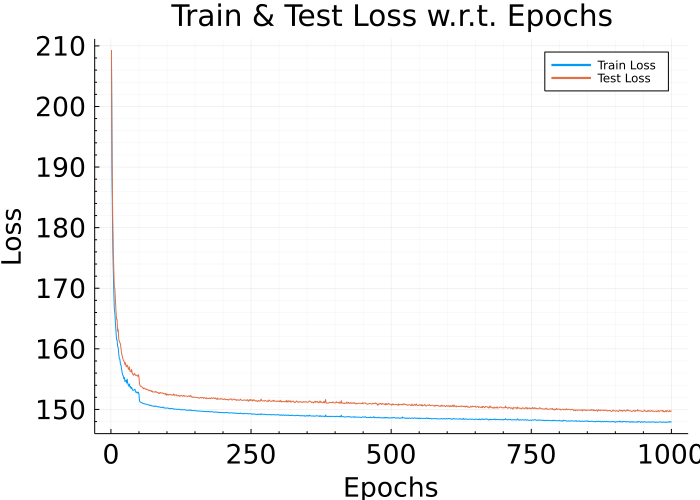

In [13]:
display(plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end]; title = "Train & Test Loss w.r.t. Epochs"))
fig_name = "Train_and_test_loss"
savefig(joinpath("Results", notebook_name, fig_name))

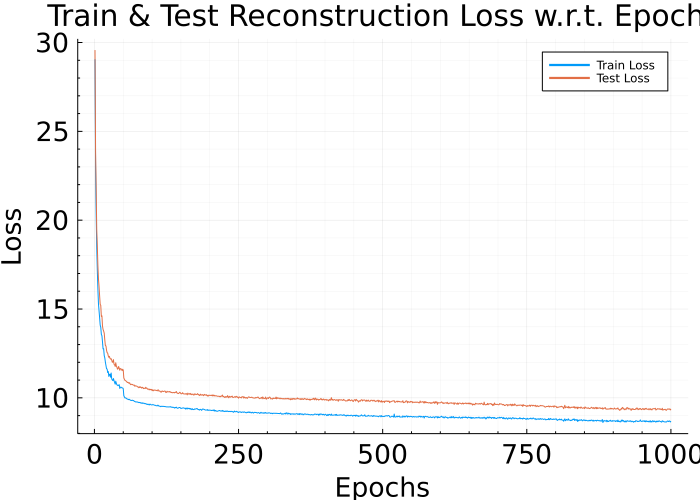

In [14]:
display(plot_loss_convergence(trn_rec_loss_list[2:end], tst_rec_loss_list[2:end]; title = "Train & Test Reconstruction Loss w.r.t. Epochs"))
fig_name = "Train_and_test_reconstruction_loss"
savefig(joinpath("Results", notebook_name, fig_name))

In [15]:
info(logger, "Training is done!")
info(logger, "We will report the last loss values for both training and test sets.\n")

# Record Training and Test Losses
epoch_loss_trn = loss_train(theta, dtrn)
epoch_loss_tst = loss_train(theta, dtst)
epoch_rec_loss_trn = rec_loss(decode_train, theta, dtrn)
epoch_rec_loss_tst = rec_loss(decode_train, theta, dtst)

info(logger,"Train Loss : $epoch_loss_trn")
info(logger,"Test Loss : $epoch_loss_tst")
info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")

[2021-12-08 21:13:10 | info | root]: Training is done!
[2021-12-08 21:13:10 | info | root]: We will report the last loss values for both training and test sets.

[2021-12-08 21:13:24 | info | root]: Train Loss : 147.87773402854245
[2021-12-08 21:13:24 | info | root]: Test Loss : 149.65584264657437
[2021-12-08 21:13:24 | info | root]: Train Reconstruction Loss : 8.6909895
[2021-12-08 21:13:24 | info | root]: Test Reconstruction Loss : 9.377888 



# Save Loss Curves

In [16]:
Knet.save(joinpath("Results", notebook_name,"trn_loss_list.jld2"),"trn_loss_list",trn_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_loss_list.jld2"),"tst_loss_list",tst_loss_list) 
Knet.save(joinpath("Results", notebook_name,"trn_rec_loss_list.jld2"),"trn_rec_loss_list",trn_rec_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_rec_loss_list.jld2"),"tst_rec_loss_list",tst_rec_loss_list) 